Beale synthetic function:

GP EI versus GP dEI (winner)

https://www.sfu.ca/~ssurjano/beale.html

In [1]:
pip install pyGPGO


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 11.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of arviz to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 

In [2]:
!pip install -q latextable


In [3]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc
rc('text', usetex=False)

from tabulate import tabulate
from texttable import Texttable

import latextable

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [4]:
### Inputs:

obj_func = 'Beale'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util = 'EI'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [5]:
### Objective function:

if obj_func == 'Beale':

    # True y bounds:
    y_lb = 0
    operator = -1 # targets global minimum
    y_global_orig = y_lb * operator # targets global minimum

# Constraints:
    lb = -4.5
    ub = +4.5

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}

# Test data:
    x1_test = np.linspace(lb, ub, n_test)
    x2_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return  operator * (
                (1.500 - x1_training + x1_training * x2_training)**2 +
                (2.250 - x1_training + x1_training * x2_training**2)**2 +
                (2.625 - x1_training + x1_training * x2_training**3)**2
                )


In [6]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [7]:
### Cumulative Regret Calculator:

def min_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [8]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [9]:
### Surrogate derivatives:

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)

def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE

    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T

        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)

        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.diag(np.dot(dKstar, alpha_Kstar))

        return dm, ds


In [10]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):
    def __init__(self, mode, eps=eps, **params):

        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]

    def EI(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        #f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        f = (std + self.eps) * (norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx
        #df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df2 = (std + self.eps) * (-gamma * norm.pdf(gamma))
        df = df1 + df2
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()

    def d_eval(self, tau, mean, std, ds, dm):

        return self.f(tau, mean, std, ds, dm, **self.params)


In [11]:
n_start_AcqFunc = 20
inverse = -1
n_start = n_start_AcqFunc

maxfunMinimize = 50 * dim # allows for both function and gradient evaluation capping, using the problem's input dimensions


In [12]:
## GPGO_approx: BayesOpt class, acquision function optimised using approximate acquisition function gradients

class GPGO_approx(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t EI exact \t EI approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncApprox = -min(self.f_best) + eps
        self.history.append(self.max_acqfuncApprox)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncExact = -min(self.f_best2) + eps
        self.history.append(self.max_acqfuncExact)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [13]:
## GPGO_exact: BayesOpt class, acquision function optimised using exact acquisition function gradients

class GPGO_exact(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t EI exact \t EI approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncExact = -min(self.f_best) + eps
        self.history.append(self.max_acqfuncExact)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncApprox = -min(self.f_best2) + eps
        self.history.append(self.max_acqfuncApprox)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)

        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [14]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_1 = GPGO_approx(surrogate_approx_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-0.74680196  1.98292044]	 6.5970295	 6.5970295	     	     	     	     	    
init	 [-4.49897063 -1.77900685]	 1305.47105896	 6.5970295	     	     	     	     	    
init	 [-3.17919698 -3.66895265]	 28173.77601348	 6.5970295	     	     	     	     	    
init	 [-2.8236581  -1.38995346]	 237.99317641	 6.5970295	     	     	     	     	    
init	 [-0.92909273  0.34935061]	 26.17906318	 6.5970295	     	     	     	     	    
1  	 [ 0.55387963 -3.60363302]	 648.8896312	 6.5970295	 38.4 	 0.79788455 	 0.79788455 	 1.0 	 5.256
2  	 [ 2.16523948 -1.48166443]	 81.74971995	 6.5970295	 38.4 	 0.79784256 	 0.79784257 	 1.0 	 8.946
3	 [1.48407448 0.23426577]	 2.19585297	 2.19585297	 46.4 	 0.7951818 	 0.79528842 	 1.0 	 6.667
4  	 [ 3.45034574 -4.5       ]	 104395.95554122	 2.19585297	 55.2 	 0.79782778 	 0.7978796 	 1.0 	 7.89
5  	 [ 0.05373024 -1.17247878]	 13.24051416	 2.19585297	 48.4 	 0.7

In [15]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_2 = GPGO_approx(surrogate_approx_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-0.57604588 -4.26666391]	 2377.84417418	 8.81624267	     	     	     	     	    
init	 [ 0.4469623  -0.58209847]	 8.81624267	 8.81624267	     	     	     	     	    
init	 [-0.71668978 -1.52698661]	 47.37426285	 8.81624267	     	     	     	     	    
init	 [-2.65816229  1.0734387 ]	 9.0886159	 8.81624267	     	     	     	     	    
init	 [-1.80310794 -2.09855452]	 510.22209437	 8.81624267	     	     	     	     	    
1  	 [-4.33713674 -2.57914825]	 7406.90057915	 8.81624267	 35.1 	 0.79669694 	 0.79774952 	 0.999 	 9.096
2  	 [ 2.40733182 -3.31884263]	 8480.14764422	 8.81624267	 39.2 	 0.79787814 	 0.79787775 	 1.0 	 4.843
3  	 [ 4.18795745 -0.28918517]	 20.49317892	 8.81624267	 38.2 	 0.79788409 	 0.79788407 	 1.0 	 7.033
4	 [2.27162023 0.21834796]	 0.2256276	 0.2256276	 33.2 	 0.79457917 	 0.79399378 	 1.001 	 5.493
5  	 [4.5       2.1935148]	 2504.68529363	 0.2256276	 24.4 

In [16]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_3 = GPGO_approx(surrogate_approx_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.45718112 1.8733304 ]	 41.91271474	 41.91271474	     	     	     	     	    
init	 [-1.88185735  0.09744845]	 47.45118839	 41.91271474	     	     	     	     	    
init	 [3.53652259 3.5666378 ]	 27475.81668992	 41.91271474	     	     	     	     	    
init	 [-3.36973221 -2.6348141 ]	 5079.048973	 41.91271474	     	     	     	     	    
init	 [-4.03679517 -0.53271141]	 138.40865241	 41.91271474	     	     	     	     	    
1  	 [-1.42905454 -0.67655357]	 44.54758778	 41.91271474	 12.8 	 0.74760209 	 0.75633497 	 0.988 	 0.666
2	 [3.16422242 0.4390174 ]	 0.2420048	 0.2420048	 4.8 	 0.00295296 	 0.79788192 	 0.004 	 0.047
3  	 [ 0.49712771 -3.22246396]	 258.64585124	 0.2420048	 26.7 	 0.79788457 	 0.79788411 	 1.0 	 4.259
4  	 [ 3.45155974 -4.5       ]	 104469.92371135	 0.2420048	 19.4 	 0.79788418 	 0.79788423 	 1.0 	 4.462
5  	 [-2.38134305  3.03095876]	 4066.35471949	 0.242004

In [17]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number =  4

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_4 = GPGO_approx(surrogate_approx_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [4.20326855 0.42509024]	 3.84098566	 3.84098566	     	     	     	     	    
init	 [4.25415924 1.93334394]	 1070.65181379	 3.84098566	     	     	     	     	    
init	 [ 1.77955942 -2.55519454]	 1001.35293114	 3.84098566	     	     	     	     	    
init	 [ 4.28647009 -4.4439277 ]	 150069.47442765	 3.84098566	     	     	     	     	    
init	 [-2.22315874 -0.58687621]	 67.08861689	 3.84098566	     	     	     	     	    
1  	 [1.46072429 3.38558155]	 3678.76756125	 3.84098566	 40.4 	 0.79768946 	 0.79787956 	 1.0 	 8.066
2  	 [-2.02115624  3.85276077]	 12988.53744846	 3.84098566	 18.6 	 0.79398466 	 0.79788414 	 0.995 	 2.293
3  	 [-4.30300036  0.49871719]	 84.32098053	 3.84098566	 12.9 	 6.379e-05 	 0.79743289 	 0.0 	 1.368
4  	 [-1.44085511 -2.69424774]	 1132.12240757	 3.84098566	 13.2 	 0.13820708 	 0.79724161 	 0.173 	 1.837
5  	 [-0.64659858  0.05227461]	 23.54671824	 3.84

In [18]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_5 = GPGO_approx(surrogate_approx_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.50206146  3.33659076]	 8263.90556807	 0.31139702	     	     	     	     	    
init	 [-2.6395276   3.76749817]	 19560.15202528	 0.31139702	     	     	     	     	    
init	 [-0.1042993   1.00569477]	 14.18657899	 0.31139702	     	     	     	     	    
init	 [2.39317071 0.16576189]	 0.31139702	 0.31139702	     	     	     	     	    
init	 [-1.82879549 -2.81050894]	 2208.98230863	 0.31139702	     	     	     	     	    
1  	 [ 0.8306235 -4.5      ]	 5802.74159564	 0.31139702	 29.8 	 0.79788457 	 0.79788457 	 1.0 	 3.404
2  	 [ 4.01612147 -3.48705358]	 31961.8727028	 0.31139702	 24.2 	 0.79788457 	 0.79788457 	 1.0 	 3.66
3  	 [1.84675278 4.49693462]	 29954.73327065	 0.31139702	 15.4 	 0.79788456 	 0.79788456 	 1.0 	 4.608
4  	 [0.79650058 0.94503882]	 13.0609546	 0.31139702	 3.0 	 1e-08 	 1e-08 	 1.0 	 0.0
5  	 [4.5        0.96070135]	 9.84656024	 0.31139702	 3.9 	 0.65842101

In [19]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_6 = GPGO_approx(surrogate_approx_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 3.53574136 -1.51218175]	 273.31220308	 10.03800071	     	     	     	     	    
init	 [ 2.89106211 -4.12473037]	 43803.25040669	 10.03800071	     	     	     	     	    
init	 [-3.53108988  0.85546858]	 29.82843375	 10.03800071	     	     	     	     	    
init	 [ 0.26835626 -0.73073314]	 10.6589253	 10.03800071	     	     	     	     	    
init	 [-1.48132936  1.10267489]	 10.03800071	 10.03800071	     	     	     	     	    
1  	 [-0.31336527 -2.53189515]	 71.49540963	 10.03800071	 38.6 	 0.76451239 	 0.79645026 	 0.96 	 4.527
2	 [ 2.05541876 -0.64789484]	 4.6793628	 4.6793628	 53.0 	 0.78097831 	 0.79289836 	 0.985 	 6.014
3  	 [-1.88385073 -1.67397527]	 222.15399807	 4.6793628	 47.1 	 0.78856273 	 0.79570379 	 0.991 	 7.608
4  	 [-4.18064379 -1.78029493]	 1142.59823946	 4.6793628	 53.7 	 0.78843056 	 0.79770067 	 0.988 	 8.915
5  	 [-3.00220756  2.04890648]	 464.62923658	 4.

In [20]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_7 = GPGO_approx(surrogate_approx_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-3.8132254   2.51926913]	 3321.1422835	 2.96769239	     	     	     	     	    
init	 [-0.55431692  2.0111866 ]	 2.96769239	 2.96769239	     	     	     	     	    
init	 [4.30190561 0.34646283]	 6.32173172	 2.96769239	     	     	     	     	    
init	 [ 0.01008417 -3.8515398 ]	 11.97189446	 2.96769239	     	     	     	     	    
init	 [-2.08404918e+00 -1.05749257e-03]	 53.82031719	 2.96769239	     	     	     	     	    
1  	 [-3.92266396 -1.25079409]	 309.00619074	 2.96769239	 47.0 	 0.77543533 	 0.79716807 	 0.973 	 9.921
2  	 [-0.85057089  4.46929615]	 5445.02843934	 2.96769239	 39.8 	 0.78880546 	 0.79766693 	 0.989 	 9.732
3  	 [2.84174722 4.42030038]	 63276.73090621	 2.96769239	 36.0 	 0.79788407 	 0.79788445 	 1.0 	 6.213
4  	 [2.02167091 3.32817731]	 6195.25865089	 2.96769239	 23.0 	 0.79788457 	 0.79788457 	 1.0 	 6.101
5  	 [-3.57158998 -3.34775722]	 21116.77907768	

In [21]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_8 = GPGO_approx(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [3.36086463 4.21686597]	 66731.07602387	 1.86933486	     	     	     	     	    
init	 [3.32275086 0.27770122]	 1.86933486	 1.86933486	     	     	     	     	    
init	 [-2.40544505 -4.39741076]	 45883.36172615	 1.86933486	     	     	     	     	    
init	 [-0.62578064 -0.87883776]	 26.39306085	 1.86933486	     	     	     	     	    
init	 [ 0.20407204 -0.19447384]	 11.649231	 1.86933486	     	     	     	     	    
1  	 [ 1.92436257 -4.5       ]	 32131.5691062	 1.86933486	 36.2 	 0.79788447 	 0.79788457 	 1.0 	 8.613
2  	 [-0.87469972  2.92781089]	 359.6738076	 1.86933486	 38.4 	 0.79788369 	 0.79788272 	 1.0 	 4.338
3  	 [-4.02741948 -0.36927625]	 129.01194157	 1.86933486	 26.2 	 0.7848963 	 0.79788381 	 0.984 	 4.388
4	 [1.75855597 0.10849989]	 1.0215068	 1.0215068	 9.4 	 0.14599836 	 0.78104323 	 0.187 	 1.338
5  	 [-0.90749151  0.39981549]	 25.32745673	 1.0215068	 3.0 	 5

In [22]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_9 = GPGO_approx(surrogate_approx_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-4.40663262  0.01687133]	 127.75319006	 22.47920466	     	     	     	     	    
init	 [-0.03804036 -3.29553424]	 22.47920466	 22.47920466	     	     	     	     	    
init	 [-3.22100023 -2.53297192]	 3783.05384026	 22.47920466	     	     	     	     	    
init	 [-0.73342638 -2.26708948]	 157.51337782	 22.47920466	     	     	     	     	    
init	 [-3.74346314 -1.39051224]	 380.77306777	 22.47920466	     	     	     	     	    
1	 [-4.14490664  1.32405042]	 8.913989	 8.913989	 3.0 	 2e-08 	 2e-08 	 1.0 	 0.0
2  	 [-2.56098154 -0.2863361 ]	 71.67605481	 8.913989	 23.0 	 0.79708859 	 0.79730473 	 1.0 	 2.233
3  	 [ 0.63940643 -1.75026397]	 14.88882182	 8.913989	 21.2 	 0.79615246 	 0.79638773 	 1.0 	 1.634
4  	 [-0.97325207 -0.71704125]	 33.12820605	 8.913989	 15.4 	 0.79662687 	 0.79671926 	 1.0 	 1.668
5  	 [-4.44770032 -4.4846581 ]	 174177.31712369	 8.913989	 20.7 	 0.78596725

In [23]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_10 = GPGO_approx(surrogate_approx_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 2.44188579 -4.31323246]	 40500.70899506	 15.22952398	     	     	     	     	    
init	 [1.20283411 2.23923494]	 281.87686993	 15.22952398	     	     	     	     	    
init	 [-0.01343689 -2.47683019]	 15.22952398	 15.22952398	     	     	     	     	    
init	 [-2.71743422  2.34477641]	 985.56374709	 15.22952398	     	     	     	     	    
init	 [-2.97800247 -3.70494167]	 26177.14611647	 15.22952398	     	     	     	     	    
1  	 [ 3.48344784 -1.48639213]	 244.2912567	 15.22952398	 19.4 	 0.79788452 	 0.79788452 	 1.0 	 0.655
2  	 [-3.88367509 -0.3258137 ]	 121.07349895	 15.22952398	 13.0 	 0.79787941 	 0.79787878 	 1.0 	 0.393
3	 [2.54951012 0.67214655]	 1.88946602	 1.88946602	 23.2 	 0.79675635 	 0.79691724 	 1.0 	 1.922
4  	 [2.96461728 2.12744433]	 980.41558922	 1.88946602	 3.0 	 1e-08 	 1e-08 	 1.0 	 0.0
5  	 [-3.95954815  4.40025277]	 114511.83585899	 1.88946602	 3.0 

In [24]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_11 = GPGO_approx(surrogate_approx_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.8775728  -4.32472283]	 59421.148191	 2.8907295	     	     	     	     	    
init	 [-0.33103326  2.02440536]	 2.8907295	 2.8907295	     	     	     	     	    
init	 [-0.71816756 -0.13115612]	 25.27144735	 2.8907295	     	     	     	     	    
init	 [-4.38497267 -0.11365553]	 133.25157969	 2.8907295	     	     	     	     	    
init	 [3.97625987 3.1571558 ]	 16859.81677191	 2.8907295	     	     	     	     	    
1  	 [ 1.40944684 -4.01257377]	 8656.45718478	 2.8907295	 43.2 	 0.79788457 	 0.79788457 	 1.0 	 5.674
2  	 [0.21169103 4.5       ]	 516.07660688	 2.8907295	 31.4 	 0.79765879 	 0.79772229 	 1.0 	 4.844
3  	 [ 4.05212839 -1.00200058]	 79.14903736	 2.8907295	 17.4 	 0.79788454 	 0.79788456 	 1.0 	 2.025
4  	 [-2.99179539  1.97056822]	 341.09465221	 2.8907295	 9.9 	 0.77414747 	 0.79760253 	 0.971 	 2.034
5  	 [0.51567617 0.8932814 ]	 12.82743678	 2.8907295	 8.6 	 0.655

In [25]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_12 = GPGO_approx(surrogate_approx_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-3.11253442  2.16044727]	 746.34127209	 48.45196617	     	     	     	     	    
init	 [-2.13016486  0.30365454]	 48.45196617	 48.45196617	     	     	     	     	    
init	 [-4.36882534  3.76872307]	 54651.23560734	 48.45196617	     	     	     	     	    
init	 [ 3.60643369 -4.19920715]	 76007.68460601	 48.45196617	     	     	     	     	    
init	 [ 4.11254403 -3.26511611]	 22941.17826205	 48.45196617	     	     	     	     	    
1	 [-1.54497549 -0.20701553]	 42.72882609	 42.72882609	 5.7 	 8.1e-07 	 0.32667033 	 0.0 	 0.421
2	 [ 1.03973961 -1.55969916]	 20.90184287	 20.90184287	 6.2 	 0.79787958 	 0.79786336 	 1.0 	 0.069
3  	 [-2.28855129 -1.34546881]	 157.31482847	 20.90184287	 8.0 	 0.00030407 	 0.78053763 	 0.0 	 0.525
4  	 [-2.2608188  -2.91185372]	 4006.82333556	 20.90184287	 9.0 	 0.74163772 	 0.78922216 	 0.94 	 0.392
5	 [-0.2649807  -0.92035238]	 18.87068166	 18.87

In [26]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_13 = GPGO_approx(surrogate_approx_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 2.4993217  -2.36212902]	 1312.05970237	 25.91775807	     	     	     	     	    
init	 [2.91850679 4.19174278]	 48757.43948599	 25.91775807	     	     	     	     	    
init	 [ 4.25341003 -0.41895677]	 25.91775807	 25.91775807	     	     	     	     	    
init	 [0.98138216 2.47973863]	 337.87505127	 25.91775807	     	     	     	     	    
init	 [1.2745201  1.99816407]	 177.13741609	 25.91775807	     	     	     	     	    
1  	 [ 3.38302988 -4.42284953]	 90628.05879831	 25.91775807	 5.1 	 0.75772929 	 0.79772886 	 0.95 	 0.021
2	 [ 4.13041259 -0.420846  ]	 23.69325077	 23.69325077	 3.0 	 1e-08 	 1e-08 	 1.0 	 0.0
3	 [ 0.04076022 -3.3990191 ]	 9.89491401	 9.89491401	 3.0 	 1e-08 	 1e-08 	 1.0 	 0.0
4  	 [0.67466029 0.87105193]	 12.09495654	 9.89491401	 8.1 	 1.101e-05 	 0.787365 	 0.0 	 1.106
5	 [2.73857587 0.79628772]	 4.05553385	 4.05553385	 22.5 	 0.54998187 	 0.79613318 	 0

In [27]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_14 = GPGO_approx(surrogate_approx_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.12549009 2.45848547]	 30.19066755	 11.36701553	     	     	     	     	    
init	 [ 3.33384917 -4.42757746]	 88548.39506592	 11.36701553	     	     	     	     	    
init	 [-1.71237667  4.11843365]	 13933.41432038	 11.36701553	     	     	     	     	    
init	 [ 0.11805041 -1.63544018]	 11.36701553	 11.36701553	     	     	     	     	    
init	 [ 0.35279944 -2.50870552]	 27.90050047	 11.36701553	     	     	     	     	    
1  	 [-3.68004339  2.25866712]	 1477.93140823	 11.36701553	 17.2 	 0.77460995 	 0.79788431 	 0.971 	 1.111
2  	 [-2.54542464 -0.35906321]	 72.51760741	 11.36701553	 8.1 	 0.00799962 	 0.79783837 	 0.01 	 0.684
3  	 [ 3.57458244 -0.36860685]	 13.48451751	 11.36701553	 15.3 	 0.0941548 	 0.79788444 	 0.118 	 2.976
4  	 [-4.5        -0.63720141]	 171.57719637	 11.36701553	 26.1 	 0.78953724 	 0.79584931 	 0.992 	 1.347
5  	 [-3.66355471 -2.49985526]	 4528.47

In [28]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_15 = GPGO_approx(surrogate_approx_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 3.13935928 -2.88993668]	 6575.87582121	 47.08268654	     	     	     	     	    
init	 [-4.01073107 -1.24615399]	 317.71090829	 47.08268654	     	     	     	     	    
init	 [-2.02139164  0.27000202]	 47.08268654	 47.08268654	     	     	     	     	    
init	 [-1.74672976 -1.75973077]	 234.87929684	 47.08268654	     	     	     	     	    
init	 [-3.49432851 -2.25090888]	 2421.67103335	 47.08268654	     	     	     	     	    
1	 [ 1.62879622 -1.31124153]	 23.99648914	 23.99648914	 4.5 	 0.79786412 	 0.79786413 	 1.0 	 0.04
2  	 [ 0.84099576 -3.25424181]	 850.5062244	 23.99648914	 9.8 	 0.71185665 	 0.79784515 	 0.892 	 1.487
3  	 [-1.21485981  0.46367923]	 28.72177039	 23.99648914	 3.2 	 9.9e-07 	 9.9e-07 	 1.0 	 0.0
4	 [3.67963568 0.49493111]	 0.77789132	 0.77789132	 3.0 	 1e-08 	 1e-08 	 1.0 	 0.0
5  	 [-2.4606006   2.80402776]	 2639.8461608	 0.77789132	 42.6 	 0.79756174 

In [29]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_16 = GPGO_approx(surrogate_approx_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.49038029  0.20847007]	 59.44289418	 59.44289418	     	     	     	     	    
init	 [ 0.45631311 -4.08958245]	 932.93744896	 59.44289418	     	     	     	     	    
init	 [-1.25344048 -2.49227152]	 594.94949578	 59.44289418	     	     	     	     	    
init	 [ 1.69853546 -3.02641717]	 2418.38944042	 59.44289418	     	     	     	     	    
init	 [-3.8670762   3.96909774]	 58473.38862292	 59.44289418	     	     	     	     	    
1	 [ 1.66505966 -0.57965018]	 2.99106622	 2.99106622	 11.8 	 0.79763184 	 0.79763067 	 1.0 	 0.401
2  	 [-0.03232268  2.05264717]	 12.40881354	 2.99106622	 17.6 	 0.79788109 	 0.79787072 	 1.0 	 3.652
3  	 [0.40399003 4.5       ]	 1632.72817884	 2.99106622	 12.3 	 0.79732623 	 0.79767803 	 1.0 	 2.606
4  	 [3.75294043 4.49999987]	 121948.23503528	 2.99106622	 22.5 	 0.79788319 	 0.79788323 	 1.0 	 3.826
5  	 [-3.90556368 -3.93033608]	 62732.63877334	 2

In [30]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_17 = GPGO_approx(surrogate_approx_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-1.84801498  0.2752808 ]	 43.39160389	 6.89162337	     	     	     	     	    
init	 [-2.77631292 -3.88889678]	 30048.58268622	 6.89162337	     	     	     	     	    
init	 [2.58286914 1.4070017 ]	 81.72560623	 6.89162337	     	     	     	     	    
init	 [1.23768806 0.68042604]	 6.89162337	 6.89162337	     	     	     	     	    
init	 [-4.14843375 -1.27967756]	 359.43439337	 6.89162337	     	     	     	     	    
1  	 [-4.45071835  0.96429485]	 18.83336161	 6.89162337	 39.6 	 0.79722791 	 0.79722351 	 1.0 	 4.131
2  	 [ 1.14457766 -3.91666291]	 4893.14056758	 6.89162337	 60.3 	 0.79788455 	 0.79788455 	 1.0 	 5.124
3  	 [ 3.42295839 -0.29692299]	 10.18628576	 6.89162337	 19.8 	 0.79505047 	 0.79507649 	 1.0 	 2.796
4  	 [4.22105189 2.35669913]	 3392.06383528	 6.89162337	 45.3 	 0.79503323 	 0.79505268 	 1.0 	 4.373
5  	 [1.53523112 4.23258468]	 14644.25132072	 6.89162337	 4

In [31]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_18 = GPGO_approx(surrogate_approx_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [1.35336818 0.04908036]	 2.47265265	 2.47265265	     	     	     	     	    
init	 [ 3.40741324 -2.86343797]	 7379.01731459	 2.47265265	     	     	     	     	    
init	 [3.17009762 2.25122657]	 1528.31014198	 2.47265265	     	     	     	     	    
init	 [1.49491501 4.39105903]	 17224.91329528	 2.47265265	     	     	     	     	    
init	 [-2.1872842  -4.24524667]	 31030.3482424	 2.47265265	     	     	     	     	    
1  	 [-2.36099367  3.19045704]	 5529.98663663	 2.47265265	 9.4 	 0.41974808 	 0.79788457 	 0.526 	 2.381
2  	 [-0.65996935 -0.25590629]	 24.50564995	 2.47265265	 10.8 	 0.78602863 	 0.79630323 	 0.987 	 0.918
3  	 [ 0.54918891 -0.20569925]	 7.96349476	 2.47265265	 6.6 	 0.72614213 	 0.72653619 	 0.999 	 0.686
4  	 [-4.49632161 -0.74320526]	 185.77878007	 2.47265265	 3.9 	 0.76864323 	 0.79788454 	 0.963 	 0.726
5  	 [ 0.72978617 -0.03463645]	 6.46036386	 2.47265

In [32]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_19 = GPGO_approx(surrogate_approx_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-3.62219758  2.35124745]	 1879.40901857	 63.54408607	     	     	     	     	    
init	 [-2.27755824 -3.25681481]	 7496.2434103	 63.54408607	     	     	     	     	    
init	 [-1.51698093 -3.75300391]	 7497.40754262	 63.54408607	     	     	     	     	    
init	 [1.54779373 2.75934418]	 1302.43419574	 63.54408607	     	     	     	     	    
init	 [4.34467723 1.22094661]	 63.54408607	 63.54408607	     	     	     	     	    
1	 [1.70872631 0.4695105 ]	 2.38983446	 2.38983446	 3.0 	 1e-08 	 1e-08 	 1.0 	 0.0
2  	 [ 2.253343   -3.76448671]	 15466.29765726	 2.38983446	 9.4 	 0.7978845 	 0.7978845 	 1.0 	 2.582
3  	 [0.22919318 0.51697962]	 12.15776069	 2.38983446	 3.0 	 1e-08 	 1e-08 	 1.0 	 0.0
4  	 [ 0.62419735 -0.4037318 ]	 7.21405983	 2.38983446	 18.0 	 0.73776121 	 0.75203271 	 0.981 	 1.335
5  	 [0.91583179 0.52736608]	 7.06178736	 2.38983446	 3.0 	 1e-08 	 1e-08 	 1.0 	 0.

In [33]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_20 = GPGO_approx(surrogate_approx_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.79317721 3.57942355]	 1607.3829987	 30.55204393	     	     	     	     	    
init	 [3.52377657 2.8425373 ]	 7209.15006059	 30.55204393	     	     	     	     	    
init	 [-4.17699373  1.72581824]	 253.68900137	 30.55204393	     	     	     	     	    
init	 [-1.09187152  0.16659851]	 30.55204393	 30.55204393	     	     	     	     	    
init	 [ 1.42156319 -2.75534804]	 963.93628383	 30.55204393	     	     	     	     	    
1	 [ 3.05216915 -0.28027678]	 6.35734148	 6.35734148	 14.7 	 0.132232 	 0.79786466 	 0.166 	 0.724
2  	 [ 4.25470914 -3.54347486]	 39417.1689959	 6.35734148	 25.6 	 0.79786101 	 0.79786655 	 1.0 	 4.192
3  	 [-2.19796148  4.46562527]	 38035.6051143	 6.35734148	 15.6 	 0.62537341 	 0.79787757 	 0.784 	 1.381
4  	 [-4.34116655 -3.92755289]	 77056.29513141	 6.35734148	 3.2 	 0.00510415 	 0.00510415 	 1.0 	 0.0
5  	 [-1.12058232 -0.8240831 ]	 38.49069859	 6.3573

In [34]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_1 = GPGO_exact(surrogate_exact_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-0.74680196  1.98292044]	 6.5970295	 6.5970295	     	     	     	     	    
init	 [-4.49897063 -1.77900685]	 1305.47105896	 6.5970295	     	     	     	     	    
init	 [-3.17919698 -3.66895265]	 28173.77601348	 6.5970295	     	     	     	     	    
init	 [-2.8236581  -1.38995346]	 237.99317641	 6.5970295	     	     	     	     	    
init	 [-0.92909273  0.34935061]	 26.17906318	 6.5970295	     	     	     	     	    
1  	 [ 0.46200985 -4.5       ]	 1720.28208868	 6.5970295	 17.4 	 0.79788455 	 0.79788455 	 1.0 	 4.471
2  	 [ 2.47241521 -2.28563584]	 1067.552435	 6.5970295	 21.5 	 0.79787866 	 0.79787866 	 1.0 	 6.112
3	 [3.81529256 0.22270975]	 5.35972475	 5.35972475	 8.8 	 0.79786915 	 0.79786915 	 1.0 	 3.976
4  	 [-4.49072016  0.62476208]	 71.27129363	 5.35972475	 16.0 	 0.79765294 	 0.79787498 	 1.0 	 6.81
5  	 [-3.13612634  1.75586692]	 144.9021543	 5.35972475	 21.6 	 0.79

In [35]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_2 = GPGO_exact(surrogate_exact_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-0.57604588 -4.26666391]	 2377.84417418	 8.81624267	     	     	     	     	    
init	 [ 0.4469623  -0.58209847]	 8.81624267	 8.81624267	     	     	     	     	    
init	 [-0.71668978 -1.52698661]	 47.37426285	 8.81624267	     	     	     	     	    
init	 [-2.65816229  1.0734387 ]	 9.0886159	 8.81624267	     	     	     	     	    
init	 [-1.80310794 -2.09855452]	 510.22209437	 8.81624267	     	     	     	     	    
1  	 [ 1.77880314 -2.22237601]	 452.474708	 8.81624267	 14.8 	 0.79669694 	 0.79774952 	 0.999 	 10.068
2  	 [ 3.06344064 -4.5       ]	 82156.69556384	 8.81624267	 12.4 	 0.79777716 	 0.79772816 	 1.0 	 16.843
3  	 [ 3.61910639 -0.93170083]	 48.66874242	 8.81624267	 18.9 	 0.79771795 	 0.79786109 	 1.0 	 9.995
4  	 [-1.29643254  0.01342625]	 35.67612206	 8.81624267	 14.2 	 0.79137489 	 0.79778575 	 0.992 	 4.991
5	 [3.59407829 0.19960508]	 4.22190378	 4.22190378	 

In [36]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_3 = GPGO_exact(surrogate_exact_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.45718112 1.8733304 ]	 41.91271474	 41.91271474	     	     	     	     	    
init	 [-1.88185735  0.09744845]	 47.45118839	 41.91271474	     	     	     	     	    
init	 [3.53652259 3.5666378 ]	 27475.81668992	 41.91271474	     	     	     	     	    
init	 [-3.36973221 -2.6348141 ]	 5079.048973	 41.91271474	     	     	     	     	    
init	 [-4.03679517 -0.53271141]	 138.40865241	 41.91271474	     	     	     	     	    
1  	 [-2.77455686  0.03935028]	 71.70677296	 41.91271474	 2.6 	 0.74760209 	 0.75633497 	 0.988 	 0.123
2	 [3.15874275 0.39234894]	 0.47203188	 0.47203188	 1.6 	 0.05245234 	 0.79788185 	 0.066 	 0.0
3  	 [ 0.0540505  -4.25686322]	 14.11633796	 0.47203188	 12.6 	 0.79788457 	 0.79788457 	 1.0 	 5.294
4  	 [ 0.45898223 -1.7703284 ]	 10.62667559	 0.47203188	 17.8 	 0.79783196 	 0.79786422 	 1.0 	 4.497
5  	 [-3.4256313   2.49649558]	 2491.41389597	 0.47203188	 

In [37]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_4 = GPGO_exact(surrogate_exact_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [4.20326855 0.42509024]	 3.84098566	 3.84098566	     	     	     	     	    
init	 [4.25415924 1.93334394]	 1070.65181379	 3.84098566	     	     	     	     	    
init	 [ 1.77955942 -2.55519454]	 1001.35293114	 3.84098566	     	     	     	     	    
init	 [ 4.28647009 -4.4439277 ]	 150069.47442765	 3.84098566	     	     	     	     	    
init	 [-2.22315874 -0.58687621]	 67.08861689	 3.84098566	     	     	     	     	    
1  	 [0.21067448 0.02348734]	 11.66344792	 3.84098566	 18.6 	 0.79768946 	 0.79787956 	 1.0 	 8.309
2	 [-1.49131379  1.41034726]	 1.39372683	 1.39372683	 20.0 	 0.7960326 	 0.79787702 	 0.998 	 11.37
3  	 [-4.5        0.4922268]	 89.76443511	 1.39372683	 9.2 	 0.79770751 	 0.79788388 	 1.0 	 2.417
4  	 [-0.14412262  1.45902101]	 11.80216615	 1.39372683	 9.9 	 0.77031633 	 0.79788152 	 0.965 	 1.033
5  	 [-4.5         3.12088464]	 18251.90824223	 1.39372683	 8.4

In [38]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_5 = GPGO_exact(surrogate_exact_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.50206146  3.33659076]	 8263.90556807	 0.31139702	     	     	     	     	    
init	 [-2.6395276   3.76749817]	 19560.15202528	 0.31139702	     	     	     	     	    
init	 [-0.1042993   1.00569477]	 14.18657899	 0.31139702	     	     	     	     	    
init	 [2.39317071 0.16576189]	 0.31139702	 0.31139702	     	     	     	     	    
init	 [-1.82879549 -2.81050894]	 2208.98230863	 0.31139702	     	     	     	     	    
1  	 [ 1.01290407 -4.1712821 ]	 5539.77112985	 0.31139702	 15.6 	 0.79788457 	 0.79788457 	 1.0 	 2.225
2  	 [ 4.22114296 -3.26548594]	 24201.3205986	 0.31139702	 15.0 	 0.79788457 	 0.79788457 	 1.0 	 7.162
3  	 [1.84850208 4.48577259]	 29576.00896358	 0.31139702	 4.8 	 0.79788456 	 0.79788456 	 1.0 	 2.415
4  	 [0.79650058 0.94503882]	 13.0609546	 0.31139702	 1.0 	 1e-08 	 1e-08 	 1.0 	 0.0
5  	 [4.5       1.1714306]	 49.28199446	 0.31139702	 2.0 	 0.5099771

In [39]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_6 = GPGO_exact(surrogate_exact_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 3.53574136 -1.51218175]	 273.31220308	 10.03800071	     	     	     	     	    
init	 [ 2.89106211 -4.12473037]	 43803.25040669	 10.03800071	     	     	     	     	    
init	 [-3.53108988  0.85546858]	 29.82843375	 10.03800071	     	     	     	     	    
init	 [ 0.26835626 -0.73073314]	 10.6589253	 10.03800071	     	     	     	     	    
init	 [-1.48132936  1.10267489]	 10.03800071	 10.03800071	     	     	     	     	    
1  	 [ 4.18516552 -0.80435345]	 51.19144973	 10.03800071	 17.1 	 0.76451239 	 0.79645026 	 0.96 	 4.193
2	 [ 2.13521198 -0.60586212]	 4.52811492	 4.52811492	 21.5 	 0.79308252 	 0.79709501 	 0.995 	 4.188
3	 [4.30273889 0.77798443]	 0.72226221	 0.72226221	 15.8 	 0.79307792 	 0.79787034 	 0.994 	 3.256
4  	 [-3.24623381  3.0936218 ]	 8825.5195997	 0.72226221	 16.3 	 0.79767014 	 0.79768432 	 1.0 	 9.793
5  	 [0.29227243 3.95806576]	 466.76600849	 0.7222622

In [40]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_7 = GPGO_exact(surrogate_exact_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-3.8132254   2.51926913]	 3321.1422835	 2.96769239	     	     	     	     	    
init	 [-0.55431692  2.0111866 ]	 2.96769239	 2.96769239	     	     	     	     	    
init	 [4.30190561 0.34646283]	 6.32173172	 2.96769239	     	     	     	     	    
init	 [ 0.01008417 -3.8515398 ]	 11.97189446	 2.96769239	     	     	     	     	    
init	 [-2.08404918e+00 -1.05749257e-03]	 53.82031719	 2.96769239	     	     	     	     	    
1  	 [-0.29022426 -2.65635819]	 76.61061956	 2.96769239	 23.2 	 0.77543533 	 0.79716807 	 0.973 	 3.822
2  	 [ 1.94762608 -2.50879938]	 1090.83634956	 2.96769239	 18.9 	 0.79703077 	 0.7977846 	 0.999 	 1.367
3	 [3.00380763 0.69454951]	 1.21653335	 1.21653335	 15.2 	 0.78116825 	 0.79778462 	 0.979 	 3.238
4  	 [1.34335087 0.85278592]	 9.7160148	 1.21653335	 12.0 	 0.79077127 	 0.79783503 	 0.991 	 0.922
5  	 [-0.30016198  3.63974921]	 135.8965543	 1.21653335

In [41]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_8 = GPGO_exact(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [3.36086463 4.21686597]	 66731.07602387	 1.86933486	     	     	     	     	    
init	 [3.32275086 0.27770122]	 1.86933486	 1.86933486	     	     	     	     	    
init	 [-2.40544505 -4.39741076]	 45883.36172615	 1.86933486	     	     	     	     	    
init	 [-0.62578064 -0.87883776]	 26.39306085	 1.86933486	     	     	     	     	    
init	 [ 0.20407204 -0.19447384]	 11.649231	 1.86933486	     	     	     	     	    
1  	 [-4.32501496 -0.51405797]	 151.09773891	 1.86933486	 9.6 	 0.79788447 	 0.79788457 	 1.0 	 2.753
2  	 [ 1.79427256 -3.29229397]	 4428.79828676	 1.86933486	 10.0 	 0.79788346 	 0.79788457 	 1.0 	 4.304
3  	 [-2.76057446  1.71030465]	 80.5885207	 1.86933486	 13.9 	 0.7978219 	 0.79788458 	 1.0 	 2.335
4  	 [-1.92090016  4.03883918]	 15642.53115766	 1.86933486	 5.8 	 0.79766666 	 0.79766733 	 1.0 	 1.495
5  	 [0.92008382 0.60599189]	 7.72223194	 1.86933486	 4.4 	

In [42]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number =  9

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_9 = GPGO_exact(surrogate_exact_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-4.40663262  0.01687133]	 127.75319006	 22.47920466	     	     	     	     	    
init	 [-0.03804036 -3.29553424]	 22.47920466	 22.47920466	     	     	     	     	    
init	 [-3.22100023 -2.53297192]	 3783.05384026	 22.47920466	     	     	     	     	    
init	 [-0.73342638 -2.26708948]	 157.51337782	 22.47920466	     	     	     	     	    
init	 [-3.74346314 -1.39051224]	 380.77306777	 22.47920466	     	     	     	     	    
1	 [-4.14490664  1.32405042]	 8.913989	 8.913989	 1.0 	 2e-08 	 2e-08 	 1.0 	 0.0
2  	 [-2.67143889 -0.22629421]	 74.08379295	 8.913989	 18.4 	 0.79708859 	 0.79730473 	 1.0 	 1.835
3  	 [ 0.68508204 -1.88503811]	 23.23796936	 8.913989	 21.1 	 0.79615691 	 0.79641269 	 1.0 	 1.662
4  	 [-0.80007882 -0.76440438]	 29.45432691	 8.913989	 14.2 	 0.79673116 	 0.79678798 	 1.0 	 6.861
5  	 [-3.06544578  1.03629193]	 11.21680354	 8.913989	 16.8 	 0.78675143 	 0

In [43]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_10 = GPGO_exact(surrogate_exact_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 2.44188579 -4.31323246]	 40500.70899506	 15.22952398	     	     	     	     	    
init	 [1.20283411 2.23923494]	 281.87686993	 15.22952398	     	     	     	     	    
init	 [-0.01343689 -2.47683019]	 15.22952398	 15.22952398	     	     	     	     	    
init	 [-2.71743422  2.34477641]	 985.56374709	 15.22952398	     	     	     	     	    
init	 [-2.97800247 -3.70494167]	 26177.14611647	 15.22952398	     	     	     	     	    
1  	 [ 3.52411379 -1.50170979]	 262.76465076	 15.22952398	 9.0 	 0.79788452 	 0.79788452 	 1.0 	 1.362
2  	 [-3.78864105 -0.22073924]	 113.44382385	 15.22952398	 6.9 	 0.7978692 	 0.79780947 	 1.0 	 0.303
3  	 [3.09805225 1.61013858]	 218.33547729	 15.22952398	 9.0 	 0.79675754 	 0.79695089 	 1.0 	 1.876
4	 [0.06840817 1.29893954]	 14.91327182	 14.91327182	 1.0 	 1e-08 	 1e-08 	 1.0 	 0.0
5  	 [2.64476013 3.86873625]	 25064.75626437	 14.91327182	 4.2 	 

In [44]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_11 = GPGO_exact(surrogate_exact_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.8775728  -4.32472283]	 59421.148191	 2.8907295	     	     	     	     	    
init	 [-0.33103326  2.02440536]	 2.8907295	 2.8907295	     	     	     	     	    
init	 [-0.71816756 -0.13115612]	 25.27144735	 2.8907295	     	     	     	     	    
init	 [-4.38497267 -0.11365553]	 133.25157969	 2.8907295	     	     	     	     	    
init	 [3.97625987 3.1571558 ]	 16859.81677191	 2.8907295	     	     	     	     	    
1  	 [ 1.41717272 -4.5       ]	 17278.28089153	 2.8907295	 11.3 	 0.79788457 	 0.79788457 	 1.0 	 3.436
2  	 [-3.11682399  2.0547034 ]	 517.3944054	 2.8907295	 8.2 	 0.79765883 	 0.79772229 	 1.0 	 1.906
3  	 [ 3.80949549 -1.22756082]	 134.03922585	 2.8907295	 4.4 	 0.79788457 	 0.79788457 	 1.0 	 0.821
4  	 [0.93353893 0.89685094]	 11.83702341	 2.8907295	 1.8 	 0.03413048 	 0.72870299 	 0.047 	 0.0
5  	 [-0.31968651  3.06182323]	 39.72186151	 2.8907295	 4.2 	 0.76219

In [45]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_12 = GPGO_exact(surrogate_exact_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-3.11253442  2.16044727]	 746.34127209	 48.45196617	     	     	     	     	    
init	 [-2.13016486  0.30365454]	 48.45196617	 48.45196617	     	     	     	     	    
init	 [-4.36882534  3.76872307]	 54651.23560734	 48.45196617	     	     	     	     	    
init	 [ 3.60643369 -4.19920715]	 76007.68460601	 48.45196617	     	     	     	     	    
init	 [ 4.11254403 -3.26511611]	 22941.17826205	 48.45196617	     	     	     	     	    
1	 [-1.13649166 -0.3104271 ]	 34.08014477	 34.08014477	 1.0 	 8.1e-07 	 0.32667033 	 0.0 	 0.0
2  	 [-1.10303296 -0.87437511]	 38.96554771	 34.08014477	 1.0 	 7e-08 	 7e-08 	 1.0 	 0.0
3  	 [-1.81592074 -1.11754894]	 80.46184766	 34.08014477	 1.8 	 0.61989677 	 0.76519624 	 0.81 	 0.0
4	 [-1.01428515  0.02956472]	 30.06571301	 30.06571301	 3.0 	 0.6792324 	 0.68708254 	 0.989 	 0.124
5  	 [-2.89186846 -1.00886825]	 130.27867694	 30.06571301	 1.6 	 0

In [46]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_13 = GPGO_exact(surrogate_exact_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 2.4993217  -2.36212902]	 1312.05970237	 25.91775807	     	     	     	     	    
init	 [2.91850679 4.19174278]	 48757.43948599	 25.91775807	     	     	     	     	    
init	 [ 4.25341003 -0.41895677]	 25.91775807	 25.91775807	     	     	     	     	    
init	 [0.98138216 2.47973863]	 337.87505127	 25.91775807	     	     	     	     	    
init	 [1.2745201  1.99816407]	 177.13741609	 25.91775807	     	     	     	     	    
1  	 [ 3.36432099 -4.42155841]	 89467.52421488	 25.91775807	 2.4 	 0.75772929 	 0.79772886 	 0.95 	 0.0
2	 [ 4.13041259 -0.420846  ]	 23.69325077	 23.69325077	 1.0 	 1e-08 	 1e-08 	 1.0 	 0.0
3	 [ 0.04076022 -3.3990191 ]	 9.89491401	 9.89491401	 1.0 	 1e-08 	 1e-08 	 1.0 	 0.0
4	 [ 1.02101621 -0.17935366]	 4.23364411	 4.23364411	 14.0 	 1.157e-05 	 0.78928765 	 0.0 	 0.0
5	 [ 2.90017629 -0.16366602]	 3.92563883	 3.92563883	 12.6 	 0.75621386 	 0.79739023 	 0

In [47]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_14 = GPGO_exact(surrogate_exact_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.12549009 2.45848547]	 30.19066755	 11.36701553	     	     	     	     	    
init	 [ 3.33384917 -4.42757746]	 88548.39506592	 11.36701553	     	     	     	     	    
init	 [-1.71237667  4.11843365]	 13933.41432038	 11.36701553	     	     	     	     	    
init	 [ 0.11805041 -1.63544018]	 11.36701553	 11.36701553	     	     	     	     	    
init	 [ 0.35279944 -2.50870552]	 27.90050047	 11.36701553	     	     	     	     	    
1  	 [ 1.20921266 -2.00717407]	 109.44983252	 11.36701553	 6.0 	 0.77460995 	 0.79788431 	 0.971 	 1.024
2  	 [1.19577547 4.04904501]	 6983.28542383	 11.36701553	 2.7 	 0.79746662 	 0.79788431 	 0.999 	 0.238
3  	 [ 3.70076258 -0.39603313]	 15.90454456	 11.36701553	 3.2 	 0.79786811 	 0.79786767 	 1.0 	 0.192
4  	 [ 3.54356462 -0.34274723]	 12.51115427	 11.36701553	 3.0 	 0.69404025 	 0.79689414 	 0.871 	 0.177
5  	 [ 3.50042931 -0.33433428]	 11.80428616	

In [48]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_15 = GPGO_exact(surrogate_exact_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 3.13935928 -2.88993668]	 6575.87582121	 47.08268654	     	     	     	     	    
init	 [-4.01073107 -1.24615399]	 317.71090829	 47.08268654	     	     	     	     	    
init	 [-2.02139164  0.27000202]	 47.08268654	 47.08268654	     	     	     	     	    
init	 [-1.74672976 -1.75973077]	 234.87929684	 47.08268654	     	     	     	     	    
init	 [-3.49432851 -2.25090888]	 2421.67103335	 47.08268654	     	     	     	     	    
1	 [ 1.91892589 -1.07760031]	 15.60788287	 15.60788287	 2.3 	 0.79786412 	 0.79786413 	 1.0 	 0.371
2  	 [-1.04318532 -0.33737944]	 32.20999225	 15.60788287	 6.2 	 0.78802945 	 0.7948262 	 0.991 	 0.742
3  	 [ 0.7764183  -3.46150486]	 1041.35812036	 15.60788287	 3.7 	 0.75679821 	 0.79788202 	 0.949 	 0.289
4  	 [-3.07307847  0.92743359]	 20.69081357	 15.60788287	 1.0 	 2.3e-07 	 2.3e-07 	 1.0 	 0.0
5	 [-1.87562241  1.1694125 ]	 6.08674154	 6.08674154	 

In [49]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_16 = GPGO_exact(surrogate_exact_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.49038029  0.20847007]	 59.44289418	 59.44289418	     	     	     	     	    
init	 [ 0.45631311 -4.08958245]	 932.93744896	 59.44289418	     	     	     	     	    
init	 [-1.25344048 -2.49227152]	 594.94949578	 59.44289418	     	     	     	     	    
init	 [ 1.69853546 -3.02641717]	 2418.38944042	 59.44289418	     	     	     	     	    
init	 [-3.8670762   3.96909774]	 58473.38862292	 59.44289418	     	     	     	     	    
1	 [ 1.59465684 -0.58040458]	 2.97927349	 2.97927349	 4.8 	 0.79763184 	 0.79763067 	 1.0 	 0.103
2  	 [0.08370826 2.31224607]	 22.21241649	 2.97927349	 8.2 	 0.79788063 	 0.79787381 	 1.0 	 1.152
3  	 [0.52520755 4.30980809]	 2090.9632116	 2.97927349	 4.9 	 0.79635784 	 0.79716318 	 0.999 	 1.222
4  	 [-4.27312823 -1.88397093]	 1524.06469145	 2.97927349	 5.6 	 0.79782509 	 0.79788376 	 1.0 	 0.545
5  	 [3.77375314 3.23961931]	 17718.8992763	 2.9792734

In [50]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_17 = GPGO_exact(surrogate_exact_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-1.84801498  0.2752808 ]	 43.39160389	 6.89162337	     	     	     	     	    
init	 [-2.77631292 -3.88889678]	 30048.58268622	 6.89162337	     	     	     	     	    
init	 [2.58286914 1.4070017 ]	 81.72560623	 6.89162337	     	     	     	     	    
init	 [1.23768806 0.68042604]	 6.89162337	 6.89162337	     	     	     	     	    
init	 [-4.14843375 -1.27967756]	 359.43439337	 6.89162337	     	     	     	     	    
1  	 [-4.5         0.95258925]	 20.51260771	 6.89162337	 12.2 	 0.79722791 	 0.79722351 	 1.0 	 3.575
2  	 [ 1.09676283 -4.5       ]	 10251.72553329	 6.89162337	 14.8 	 0.79788455 	 0.79788455 	 1.0 	 4.94
3  	 [2.65113827 3.29687513]	 9885.72653219	 6.89162337	 9.2 	 0.79505019 	 0.79505903 	 1.0 	 4.961
4  	 [ 3.5285532 -4.5      ]	 109214.60831088	 6.89162337	 14.0 	 0.7978844 	 0.7978844 	 1.0 	 4.182
5  	 [-2.60478185  1.66609389]	 52.17043711	 6.89162337	 10.

In [51]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_18 = GPGO_exact(surrogate_exact_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [1.35336818 0.04908036]	 2.47265265	 2.47265265	     	     	     	     	    
init	 [ 3.40741324 -2.86343797]	 7379.01731459	 2.47265265	     	     	     	     	    
init	 [3.17009762 2.25122657]	 1528.31014198	 2.47265265	     	     	     	     	    
init	 [1.49491501 4.39105903]	 17224.91329528	 2.47265265	     	     	     	     	    
init	 [-2.1872842  -4.24524667]	 31030.3482424	 2.47265265	     	     	     	     	    
1  	 [-2.07798146  1.48303324]	 4.6102245	 2.47265265	 4.0 	 0.41974808 	 0.79788457 	 0.526 	 0.0
2  	 [-0.80478473 -0.34509282]	 27.41609746	 2.47265265	 5.2 	 0.79637268 	 0.79787563 	 0.998 	 0.99
3  	 [ 0.44200248 -0.1599484 ]	 9.04221833	 2.47265265	 8.2 	 0.73578775 	 0.79786136 	 0.922 	 1.245
4  	 [-4.5        -0.75880415]	 188.57987307	 2.47265265	 6.2 	 0.79788265 	 0.79787911 	 1.0 	 0.777
5  	 [-3.43983276  1.82154809]	 251.35580514	 2.47265265	 7.2

In [52]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_19 = GPGO_exact(surrogate_exact_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-3.62219758  2.35124745]	 1879.40901857	 63.54408607	     	     	     	     	    
init	 [-2.27755824 -3.25681481]	 7496.2434103	 63.54408607	     	     	     	     	    
init	 [-1.51698093 -3.75300391]	 7497.40754262	 63.54408607	     	     	     	     	    
init	 [1.54779373 2.75934418]	 1302.43419574	 63.54408607	     	     	     	     	    
init	 [4.34467723 1.22094661]	 63.54408607	 63.54408607	     	     	     	     	    
1	 [1.70872631 0.4695105 ]	 2.38983446	 2.38983446	 1.0 	 1e-08 	 1e-08 	 1.0 	 0.0
2  	 [ 2.20912415 -4.31696629]	 33242.91090817	 2.38983446	 4.0 	 0.7978845 	 0.7978845 	 1.0 	 1.595
3  	 [0.22919318 0.51697962]	 12.15776069	 2.38983446	 1.0 	 1e-08 	 1e-08 	 1.0 	 0.0
4  	 [-0.13579626 -0.19043368]	 16.0568269	 2.38983446	 4.7 	 0.74112762 	 0.76944161 	 0.963 	 0.118
5  	 [0.91583179 0.52736608]	 7.06178736	 2.38983446	 1.0 	 1e-08 	 1e-08 	 1.0 	 0.0

In [53]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_20 = GPGO_exact(surrogate_exact_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.79317721 3.57942355]	 1607.3829987	 30.55204393	     	     	     	     	    
init	 [3.52377657 2.8425373 ]	 7209.15006059	 30.55204393	     	     	     	     	    
init	 [-4.17699373  1.72581824]	 253.68900137	 30.55204393	     	     	     	     	    
init	 [-1.09187152  0.16659851]	 30.55204393	 30.55204393	     	     	     	     	    
init	 [ 1.42156319 -2.75534804]	 963.93628383	 30.55204393	     	     	     	     	    
1	 [ 3.05548131 -0.35064543]	 7.40126792	 7.40126792	 3.5 	 0.132232 	 0.79786466 	 0.166 	 0.0
2  	 [ 4.28189788 -3.13749308]	 19802.62106737	 7.40126792	 7.1 	 0.79785129 	 0.79785941 	 1.0 	 0.206
3	 [ 2.07649149 -0.33351884]	 1.99636006	 1.99636006	 7.4 	 0.75757756 	 0.79787509 	 0.949 	 0.327
4  	 [-4.34116655 -3.92755289]	 77056.29513141	 1.99636006	 2.0 	 0.48483292 	 0.79687871 	 0.608 	 0.0
5  	 [-3.33375851  4.5       ]	 92640.77913503	 1.99636006

In [54]:
### Simple regret minimisation: run number = 1

approx_output_1 = np.append(np.max(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+max_iter)])
exact_output_1 = np.append(np.max(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+max_iter)])

regret_approx_1 = np.log(y_global_orig - approx_output_1)
regret_exact_1 = np.log(y_global_orig - exact_output_1)

simple_regret_approx_1 = min_array(regret_approx_1)
simple_regret_exact_1 = min_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(0.16070742818774647, 0.24975549131557723)

In [55]:
### Simple regret minimisation: run number = 2

approx_output_2 = np.append(np.max(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+max_iter)])
exact_output_2 = np.append(np.max(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+max_iter)])

regret_approx_2 = np.log(y_global_orig - approx_output_2)
regret_exact_2 = np.log(y_global_orig - exact_output_2)

simple_regret_approx_2 = min_array(regret_approx_2)
simple_regret_exact_2 = min_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(-1.488869414912842, 0.4739042301021693)

In [56]:
### Simple regret minimisation: run number = 3

approx_output_3 = np.append(np.max(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+max_iter)])
exact_output_3 = np.append(np.max(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+max_iter)])

regret_approx_3 = np.log(y_global_orig - approx_output_3)
regret_exact_3 = np.log(y_global_orig - exact_output_3)

simple_regret_approx_3 = min_array(regret_approx_3)
simple_regret_exact_3 = min_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3


(-1.8184710234305, -0.9333642093543512)

In [57]:
### Simple regret minimisation: run number = 4

approx_output_4 = np.append(np.max(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+max_iter)])
exact_output_4 = np.append(np.max(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+max_iter)])

regret_approx_4 = np.log(y_global_orig - approx_output_4)
regret_exact_4 = np.log(y_global_orig - exact_output_4)

simple_regret_approx_4 = min_array(regret_approx_4)
simple_regret_exact_4 = min_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4


(-1.3780375766885986, -2.1266463442484316)

In [58]:
### Simple regret minimisation: run number = 5

approx_output_5 = np.append(np.max(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+max_iter)])
exact_output_5 = np.append(np.max(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+max_iter)])

regret_approx_5 = np.log(y_global_orig - approx_output_5)
regret_exact_5 = np.log(y_global_orig - exact_output_5)

simple_regret_approx_5 = min_array(regret_approx_5)
simple_regret_exact_5 = min_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5


(-1.1666865916873388, -2.2012074320682573)

In [59]:
### Simple regret minimisation: run number = 6

approx_output_6 = np.append(np.max(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+max_iter)])
exact_output_6 = np.append(np.max(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+max_iter)])

regret_approx_6 = np.log(y_global_orig - approx_output_6)
regret_exact_6 = np.log(y_global_orig - exact_output_6)

simple_regret_approx_6 = min_array(regret_approx_6)
simple_regret_exact_6 = min_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6


(-1.2548671409799659, -0.325367028161726)

In [60]:
### Simple regret minimisation: run number = 7

approx_output_7 = np.append(np.max(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+max_iter)])
exact_output_7 = np.append(np.max(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+max_iter)])

regret_approx_7 = np.log(y_global_orig - approx_output_7)
regret_exact_7 = np.log(y_global_orig - exact_output_7)

simple_regret_approx_7 = min_array(regret_approx_7)
simple_regret_exact_7 = min_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7


(0.16495264668945572, 0.1960052973198707)

In [61]:
### Simple regret minimisation: run number = 8

approx_output_8 = np.append(np.max(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+max_iter)])
exact_output_8 = np.append(np.max(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+max_iter)])

regret_approx_8 = np.log(y_global_orig - approx_output_8)
regret_exact_8 = np.log(y_global_orig - exact_output_8)

simple_regret_approx_8 = min_array(regret_approx_8)
simple_regret_exact_8 = min_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8


(-0.22292705607208335, -0.2698814682489426)

In [62]:
### Simple regret minimisation: run number = 9

approx_output_9 = np.append(np.max(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+max_iter)])
exact_output_9 = np.append(np.max(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+max_iter)])

regret_approx_9 = np.log(y_global_orig - approx_output_9)
regret_exact_9 = np.log(y_global_orig - exact_output_9)

simple_regret_approx_9 = min_array(regret_approx_9)
simple_regret_exact_9 = min_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9


(1.0472125230600027, 0.12336133436859054)

In [63]:
### Simple regret minimisation: run number = 10

approx_output_10 = np.append(np.max(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+max_iter)])
exact_output_10 = np.append(np.max(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+max_iter)])

regret_approx_10 = np.log(y_global_orig - approx_output_10)
regret_exact_10 = np.log(y_global_orig - exact_output_10)

simple_regret_approx_10 = min_array(regret_approx_10)
simple_regret_exact_10 = min_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10


(0.45840231801014136, -1.0936863755529485)

In [64]:
### Simple regret minimisation: run number = 11

approx_output_11 = np.append(np.max(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+max_iter)])
exact_output_11 = np.append(np.max(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+max_iter)])

regret_approx_11 = np.log(y_global_orig - approx_output_11)
regret_exact_11 = np.log(y_global_orig - exact_output_11)

simple_regret_approx_11 = min_array(regret_approx_11)
simple_regret_exact_11 = min_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11


(0.7288382530407874, 0.7530080473551314)

In [65]:
### Simple regret minimisation: run number = 12

approx_output_12 = np.append(np.max(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+max_iter)])
exact_output_12 = np.append(np.max(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+max_iter)])

regret_approx_12 = np.log(y_global_orig - approx_output_12)
regret_exact_12 = np.log(y_global_orig - exact_output_12)

simple_regret_approx_12 = min_array(regret_approx_12)
simple_regret_exact_12 = min_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12


(-0.29552754168001244, 0.8281747086322877)

In [66]:
### Simple regret minimisation: run number = 13

approx_output_13 = np.append(np.max(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+max_iter)])
exact_output_13 = np.append(np.max(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+max_iter)])

regret_approx_13 = np.log(y_global_orig - approx_output_13)
regret_exact_13 = np.log(y_global_orig - exact_output_13)

simple_regret_approx_13 = min_array(regret_approx_13)
simple_regret_exact_13 = min_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13


(-0.6000771892781469, 0.0547122141869374)

In [67]:
### Simple regret minimisation: run number = 14

approx_output_14 = np.append(np.max(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+max_iter)])
exact_output_14 = np.append(np.max(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+max_iter)])

regret_approx_14 = np.log(y_global_orig - approx_output_14)
regret_exact_14 = np.log(y_global_orig - exact_output_14)

simple_regret_approx_14 = min_array(regret_approx_14)
simple_regret_exact_14 = min_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14


(1.377501776724445, -0.26263931508633026)

In [68]:
### Simple regret minimisation: run number = 15

approx_output_15 = np.append(np.max(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+max_iter)])
exact_output_15 = np.append(np.max(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+max_iter)])

regret_approx_15 = np.log(y_global_orig - approx_output_15)
regret_exact_15 = np.log(y_global_orig - exact_output_15)

simple_regret_approx_15 = min_array(regret_approx_15)
simple_regret_exact_15 = min_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15


(-0.2511684547939706, 0.20926197528264728)

In [69]:
### Simple regret minimisation: run number = 16

approx_output_16 = np.append(np.max(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+max_iter)])
exact_output_16 = np.append(np.max(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+max_iter)])

regret_approx_16 = np.log(y_global_orig - approx_output_16)
regret_exact_16 = np.log(y_global_orig - exact_output_16)

simple_regret_approx_16 = min_array(regret_approx_16)
simple_regret_exact_16 = min_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16


(-1.400710221070254, 0.6093476918971756)

In [70]:
### Simple regret minimisation: run number = 17

approx_output_17 = np.append(np.max(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+max_iter)])
exact_output_17 = np.append(np.max(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+max_iter)])

regret_approx_17 = np.log(y_global_orig - approx_output_17)
regret_exact_17 = np.log(y_global_orig - exact_output_17)

simple_regret_approx_17 = min_array(regret_approx_17)
simple_regret_exact_17 = min_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17


(-1.7776331005072483, 1.83640607903503)

In [71]:
### Simple regret minimisation: run number = 18

approx_output_18 = np.append(np.max(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+max_iter)])
exact_output_18 = np.append(np.max(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+max_iter)])

regret_approx_18 = np.log(y_global_orig - approx_output_18)
regret_exact_18 = np.log(y_global_orig - exact_output_18)

simple_regret_approx_18 = min_array(regret_approx_18)
simple_regret_exact_18 = min_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18


(0.38120661329448713, 0.9052915200747084)

In [72]:
### Simple regret minimisation: run number = 19

approx_output_19 = np.append(np.max(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+max_iter)])
exact_output_19 = np.append(np.max(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+max_iter)])

regret_approx_19 = np.log(y_global_orig - approx_output_19)
regret_exact_19 = np.log(y_global_orig - exact_output_19)

simple_regret_approx_19 = min_array(regret_approx_19)
simple_regret_exact_19 = min_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19


(-0.01977629888982441, -1.6196631504367758)

In [73]:
### Simple regret minimisation: run number = 20

approx_output_20 = np.append(np.max(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+max_iter)])
exact_output_20 = np.append(np.max(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+max_iter)])

regret_approx_20 = np.log(y_global_orig - approx_output_20)
regret_exact_20 = np.log(y_global_orig - exact_output_20)

simple_regret_approx_20 = min_array(regret_approx_20)
simple_regret_exact_20 = min_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20


(-1.3622484717508887, -1.3622484717508887)

In [74]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]


In [75]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]


In [76]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]


In [77]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]


In [78]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]


In [79]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]


In [80]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]


In [81]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]


In [82]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]


In [83]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]


In [84]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]


In [85]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]


In [86]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]


In [87]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]


In [88]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]


In [89]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]


In [90]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]


In [91]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]


In [92]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]


In [93]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]


In [94]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]


In [95]:
def extractAcqFuncExact(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-1][::-5]
    return new_array

def extractAcqFuncApprox(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-2][::-5]
    return new_array

def extractTau(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-5][::-5]*-1
    return new_array

def extractNFev(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-3][::-5]
    return new_array

def extractEuclid(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-4][::-5]
    return new_array

In [96]:
exact_1.history


[-6.597029498756062,
 0.7978845538740286,
 0.7978845519899196,
 17.4,
 4.471323038792963,
 -6.597029498756062,
 0.7978786609766446,
 0.7978786610808591,
 21.5,
 6.11176156364039,
 -6.597029498756062,
 0.7978691466706058,
 0.7978691480477713,
 8.8,
 3.975739139988842,
 -5.35972475012351,
 0.7976529442124101,
 0.7978749834823556,
 16.0,
 6.8102200596278655,
 -5.35972475012351,
 0.7941979057048507,
 0.7978749827348428,
 21.6,
 4.693429928694489,
 -5.35972475012351,
 0.7973397965387786,
 0.7974251636263424,
 6.0,
 1.2781407801599416,
 -3.3089877941437935,
 0.7976543334951471,
 0.7976644619702697,
 13.0,
 3.4725000030755258,
 -3.3089877941437935,
 0.7690095446764666,
 0.7940000237073032,
 8.9,
 3.096042516483322,
 -3.3089877941437935,
 0.7978845702865075,
 0.7978845722056137,
 19.6,
 1.5221390650266315,
 -3.3089877941437935,
 0.7484256651580498,
 0.7486523076647844,
 3.9,
 0.6353970508179786,
 -2.6779904800122942,
 0.1989965809815654,
 0.3254984969153439,
 3.9,
 0.0,
 -2.6779904800122942,
 

In [97]:
exact1_acqFuncExactVector = extractAcqFuncExact(exact_1.history)
exact1_acqFuncApproxVector = extractAcqFuncApprox(exact_1.history)
exact1_tauVector = extractTau(exact_1.history)
approx1_tauVector = extractTau(approx_1.history)
exact1_tau = min(exact1_tauVector)
approx1_tau = min(approx1_tauVector)
exact1_acqFuncExactBest = exact1_acqFuncExactVector[np.argmin(exact1_tauVector)]
exact1_acqFuncApproxBest = exact1_acqFuncApproxVector[np.argmin(exact1_tauVector)]

exact1_acqFuncExactBest, exact1_acqFuncApproxBest, exact1_tau, approx1_tau

exact1_tauVector

array([6.5970295 , 6.5970295 , 5.35972475, 5.35972475, 5.35972475,
       3.30898779, 3.30898779, 3.30898779, 3.30898779, 2.67799048,
       2.67799048, 2.67799048, 2.67799048, 2.52010603, 2.52010603,
       2.52010603, 1.2837115 , 1.2837115 , 1.2837115 , 1.2837115 ])

In [98]:
exact2_acqFuncExactVector = extractAcqFuncExact(exact_2.history)
exact2_acqFuncApproxVector = extractAcqFuncApprox(exact_2.history)
exact2_tauVector = extractTau(exact_2.history)
approx2_tauVector = extractTau(approx_2.history)
exact2_tau = min(exact2_tauVector)
approx2_tau = min(approx2_tauVector)
exact2_acqFuncExactBest = exact2_acqFuncExactVector[np.argmin(exact2_tauVector)]
exact2_acqFuncApproxBest = exact2_acqFuncApproxVector[np.argmin(exact2_tauVector)]

exact2_acqFuncExactBest, exact2_acqFuncApproxBest, exact2_tau, approx2_tau


(0.7964733855928819,
 0.7964762336593108,
 1.6062531489610838,
 0.2256276025953579)

In [99]:
exact3_acqFuncExactVector = extractAcqFuncExact(exact_3.history)
exact3_acqFuncApproxVector = extractAcqFuncApprox(exact_3.history)
exact3_tauVector = extractTau(exact_3.history)
approx3_tauVector = extractTau(approx_3.history)
exact3_tau = min(exact3_tauVector)
approx3_tau = min(approx3_tauVector)
exact3_acqFuncExactBest = exact3_acqFuncExactVector[np.argmin(exact3_tauVector)]
exact3_acqFuncApproxBest = exact3_acqFuncApproxVector[np.argmin(exact3_tauVector)]

exact3_acqFuncExactBest, exact3_acqFuncApproxBest, exact3_tau, approx3_tau


(0.6703054457297833,
 0.742246010133214,
 0.39322857934727756,
 0.16227367399669246)

In [100]:
exact4_acqFuncExactVector = extractAcqFuncExact(exact_4.history)
exact4_acqFuncApproxVector = extractAcqFuncApprox(exact_4.history)
exact4_tauVector = extractTau(exact_4.history)
approx4_tauVector = extractTau(approx_4.history)
exact4_tau = min(exact4_tauVector)
approx4_tau = min(approx4_tauVector)
exact4_acqFuncExactBest = exact4_acqFuncExactVector[np.argmin(exact4_tauVector)]
exact4_acqFuncApproxBest = exact4_acqFuncApproxVector[np.argmin(exact4_tauVector)]

exact4_acqFuncExactBest, exact4_acqFuncApproxBest, exact4_tau, approx4_tau


(1.004526916758036e-08,
 1.004526916758036e-08,
 0.11923650225605985,
 0.2520727414217129)

In [101]:
exact5_acqFuncExactVector = extractAcqFuncExact(exact_5.history)
exact5_acqFuncApproxVector = extractAcqFuncApprox(exact_5.history)
exact5_tauVector = extractTau(exact_5.history)
approx5_tauVector = extractTau(approx_5.history)
exact5_tau = min(exact5_tauVector)
approx5_tau = min(approx5_tauVector)
exact5_acqFuncExactBest = exact5_acqFuncExactVector[np.argmin(exact5_tauVector)]
exact5_acqFuncApproxBest = exact5_acqFuncApproxVector[np.argmin(exact5_tauVector)]

exact5_acqFuncExactBest, exact5_acqFuncApproxBest, exact5_tau, approx5_tau


(0.5122414102023929, 0.66916293417726, 0.11066945181269505, 0.311397019260738)

In [102]:
exact6_acqFuncExactVector = extractAcqFuncExact(exact_6.history)
exact6_acqFuncApproxVector = extractAcqFuncApprox(exact_6.history)
exact6_tauVector = extractTau(exact_6.history)
approx6_tauVector = extractTau(approx_6.history)
exact6_tau = min(exact6_tauVector)
approx6_tau = min(approx6_tauVector)
exact6_acqFuncExactBest = exact6_acqFuncExactVector[np.argmin(exact6_tauVector)]
exact6_acqFuncApproxBest = exact6_acqFuncApproxVector[np.argmin(exact6_tauVector)]

exact6_acqFuncExactBest, exact6_acqFuncApproxBest, exact6_tau, approx6_tau


(0.7930779241817975, 0.7978703404499515, 0.722262214415426, 0.2851137256384064)

In [103]:
exact7_acqFuncExactVector = extractAcqFuncExact(exact_7.history)
exact7_acqFuncApproxVector = extractAcqFuncApprox(exact_7.history)
exact7_tauVector = extractTau(exact_7.history)
approx7_tauVector = extractTau(approx_7.history)
exact7_tau = min(exact7_tauVector)
approx7_tau = min(approx7_tauVector)
exact7_acqFuncExactBest = exact7_acqFuncExactVector[np.argmin(exact7_tauVector)]
exact7_acqFuncApproxBest = exact7_acqFuncApproxVector[np.argmin(exact7_tauVector)]

exact7_acqFuncExactBest, exact7_acqFuncApproxBest, exact7_tau, approx7_tau


(0.7811682495446346, 0.7977846207149643, 1.216533349683534, 1.1793372718650634)

In [104]:
exact8_acqFuncExactVector = extractAcqFuncExact(exact_8.history)
exact8_acqFuncApproxVector = extractAcqFuncApprox(exact_8.history)
exact8_tauVector = extractTau(exact_8.history)
approx8_tauVector = extractTau(approx_8.history)
exact8_tau = min(exact8_tauVector)
approx8_tau = min(approx8_tauVector)
exact8_acqFuncExactBest = exact8_acqFuncExactVector[np.argmin(exact8_tauVector)]
exact8_acqFuncApproxBest = exact8_acqFuncApproxVector[np.argmin(exact8_tauVector)]

exact8_acqFuncExactBest, exact8_acqFuncApproxBest, exact8_tau, approx8_tau


(0.694716555085874, 0.6949278300005348, 0.7634699844079056, 0.8001732149431301)

In [105]:
exact9_acqFuncExactVector = extractAcqFuncExact(exact_9.history)
exact9_acqFuncApproxVector = extractAcqFuncApprox(exact_9.history)
exact9_tauVector = extractTau(exact_9.history)
approx9_tauVector = extractTau(approx_9.history)
exact9_tau = min(exact9_tauVector)
approx9_tau = min(approx9_tauVector)
exact9_acqFuncExactBest = exact9_acqFuncExactVector[np.argmin(exact9_tauVector)]
exact9_acqFuncApproxBest = exact9_acqFuncApproxVector[np.argmin(exact9_tauVector)]

exact9_acqFuncExactBest, exact9_acqFuncApproxBest, exact9_tau, approx9_tau


(4.156096332958127e-06,
 0.6874233898008125,
 1.1312931221901372,
 2.8496965731748127)

In [106]:
exact10_acqFuncExactVector = extractAcqFuncExact(exact_10.history)
exact10_acqFuncApproxVector = extractAcqFuncApprox(exact_10.history)
exact10_tauVector = extractTau(exact_10.history)
approx10_tauVector = extractTau(approx_10.history)
exact10_tau = min(exact10_tauVector)
approx10_tau = min(approx10_tauVector)
exact10_acqFuncExactBest = exact10_acqFuncExactVector[np.argmin(exact10_tauVector)]
exact10_acqFuncApproxBest = exact10_acqFuncApproxVector[np.argmin(exact10_tauVector)]

exact10_acqFuncExactBest, exact10_acqFuncApproxBest, exact10_tau, approx10_tau


(0.7481982529719238,
 0.7553331079491304,
 0.33497935512354277,
 1.5815451591856984)

In [107]:
exact11_acqFuncExactVector = extractAcqFuncExact(exact_11.history)
exact11_acqFuncApproxVector = extractAcqFuncApprox(exact_11.history)
exact11_tauVector = extractTau(exact_11.history)
approx11_tauVector = extractTau(approx_11.history)
exact11_tau = min(exact11_tauVector)
approx11_tau = min(approx11_tauVector)
exact11_acqFuncExactBest = exact11_acqFuncExactVector[np.argmin(exact11_tauVector)]
exact11_acqFuncApproxBest = exact11_acqFuncApproxVector[np.argmin(exact11_tauVector)]

exact11_acqFuncExactBest, exact11_acqFuncApproxBest, exact11_tau, approx11_tau


(0.07111726931961299,
 0.6910049405231793,
 2.1233776402014306,
 2.072671288868414)

In [108]:
exact12_acqFuncExactVector = extractAcqFuncExact(exact_12.history)
exact12_acqFuncApproxVector = extractAcqFuncApprox(exact_12.history)
exact12_tauVector = extractTau(exact_12.history)
approx12_tauVector = extractTau(approx_12.history)
exact12_tau = min(exact12_tauVector)
approx12_tau = min(approx12_tauVector)
exact12_acqFuncExactBest = exact12_acqFuncExactVector[np.argmin(exact12_tauVector)]
exact12_acqFuncApproxBest = exact12_acqFuncApproxVector[np.argmin(exact12_tauVector)]

exact12_acqFuncExactBest, exact12_acqFuncApproxBest, exact12_tau, approx12_tau


(0.6751255735013634,
 0.7978620554739404,
 2.2891365833527573,
 0.7441389196048734)

In [109]:
exact13_acqFuncExactVector = extractAcqFuncExact(exact_13.history)
exact13_acqFuncApproxVector = extractAcqFuncApprox(exact_13.history)
exact13_tauVector = extractTau(exact_13.history)
approx13_tauVector = extractTau(approx_13.history)
exact13_tau = min(exact13_tauVector)
approx13_tau = min(approx13_tauVector)
exact13_acqFuncExactBest = exact13_acqFuncExactVector[np.argmin(exact13_tauVector)]
exact13_acqFuncApproxBest = exact13_acqFuncApproxVector[np.argmin(exact13_tauVector)]

exact13_acqFuncExactBest, exact13_acqFuncApproxBest, exact13_tau, approx13_tau


(0.5387335960633843,
 0.7782924790958089,
 1.0562366010231725,
 0.5487692753549162)

In [110]:
exact14_acqFuncExactVector = extractAcqFuncExact(exact_14.history)
exact14_acqFuncApproxVector = extractAcqFuncApprox(exact_14.history)
exact14_tauVector = extractTau(exact_14.history)
approx14_tauVector = extractTau(approx_14.history)
exact14_tau = min(exact14_tauVector)
approx14_tau = min(approx14_tauVector)
exact14_acqFuncExactBest = exact14_acqFuncExactVector[np.argmin(exact14_tauVector)]
exact14_acqFuncApproxBest = exact14_acqFuncApproxVector[np.argmin(exact14_tauVector)]

exact14_acqFuncExactBest, exact14_acqFuncApproxBest, exact14_tau, approx14_tau


(0.15709187304829114,
 0.795739089304659,
 0.7690192209262419,
 3.9649838293261928)

In [111]:
exact15_acqFuncExactVector = extractAcqFuncExact(exact_15.history)
exact15_acqFuncApproxVector = extractAcqFuncApprox(exact_15.history)
exact15_tauVector = extractTau(exact_15.history)
approx15_tauVector = extractTau(approx_15.history)
exact15_tau = min(exact15_tauVector)
approx15_tau = min(approx15_tauVector)
exact15_acqFuncExactBest = exact15_acqFuncExactVector[np.argmin(exact15_tauVector)]
exact15_acqFuncApproxBest = exact15_acqFuncApproxVector[np.argmin(exact15_tauVector)]

exact15_acqFuncExactBest, exact15_acqFuncApproxBest, exact15_tau, approx15_tau


(1.0000000000017182e-08,
 1.0000000000017182e-08,
 1.2327679109527818,
 0.7778913209990093)

In [112]:
exact16_acqFuncExactVector = extractAcqFuncExact(exact_16.history)
exact16_acqFuncApproxVector = extractAcqFuncApprox(exact_16.history)
exact16_tauVector = extractTau(exact_16.history)
approx16_tauVector = extractTau(approx_16.history)
exact16_tau = min(exact16_tauVector)
approx16_tau = min(approx16_tauVector)
exact16_acqFuncExactBest = exact16_acqFuncExactVector[np.argmin(exact16_tauVector)]
exact16_acqFuncApproxBest = exact16_acqFuncApproxVector[np.argmin(exact16_tauVector)]

exact16_acqFuncExactBest, exact16_acqFuncApproxBest, exact16_tau, approx16_tau


(0.6452838641845896, 0.6729371908034458, 1.8392312619395685, 0.24642188776071)

In [113]:
exact17_acqFuncExactVector = extractAcqFuncExact(exact_17.history)
exact17_acqFuncApproxVector = extractAcqFuncApprox(exact_17.history)
exact17_tauVector = extractTau(exact_17.history)
approx17_tauVector = extractTau(approx_17.history)
exact17_tau = min(exact17_tauVector)
approx17_tau = min(approx17_tauVector)
exact17_acqFuncExactBest = exact17_acqFuncExactVector[np.argmin(exact17_tauVector)]
exact17_acqFuncApproxBest = exact17_acqFuncApproxVector[np.argmin(exact17_tauVector)]

exact17_acqFuncExactBest, exact17_acqFuncApproxBest, exact17_tau, approx17_tau


(0.7905826055042999,
 0.7978415628187001,
 6.273949615380608,
 0.16903776956015965)

In [114]:
exact18_acqFuncExactVector = extractAcqFuncExact(exact_18.history)
exact18_acqFuncApproxVector = extractAcqFuncApprox(exact_18.history)
exact18_tauVector = extractTau(exact_18.history)
approx18_tauVector = extractTau(approx_18.history)
exact18_tau = min(exact18_tauVector)
approx18_tau = min(approx18_tauVector)
exact18_acqFuncExactBest = exact18_acqFuncExactVector[np.argmin(exact18_tauVector)]
exact18_acqFuncApproxBest = exact18_acqFuncApproxVector[np.argmin(exact18_tauVector)]

exact18_acqFuncExactBest, exact18_acqFuncApproxBest, exact18_tau, approx18_tau


(0.4197480829295538, 0.7978845675468373, 2.472652645883837, 1.4640500663699316)

In [115]:
exact19_acqFuncExactVector = extractAcqFuncExact(exact_19.history)
exact19_acqFuncApproxVector = extractAcqFuncApprox(exact_19.history)
exact19_tauVector = extractTau(exact_19.history)
approx19_tauVector = extractTau(approx_19.history)
exact19_tau = min(exact19_tauVector)
approx19_tau = min(approx19_tauVector)
exact19_acqFuncExactBest = exact19_acqFuncExactVector[np.argmin(exact19_tauVector)]
exact19_acqFuncApproxBest = exact19_acqFuncApproxVector[np.argmin(exact19_tauVector)]

exact19_acqFuncExactBest, exact19_acqFuncApproxBest, exact19_tau, approx19_tau


(1e-08, 1e-08, 0.1979653724027724, 0.9804179693656381)

In [116]:
exact20_acqFuncExactVector = extractAcqFuncExact(exact_20.history)
exact20_acqFuncApproxVector = extractAcqFuncApprox(exact_20.history)
exact20_tauVector = extractTau(exact_20.history)
approx20_tauVector = extractTau(approx_20.history)
exact20_tau = min(exact20_tauVector)
approx20_tau = min(approx20_tauVector)
exact20_acqFuncExactBest = exact20_acqFuncExactVector[np.argmin(exact20_tauVector)]
exact20_acqFuncApproxBest = exact20_acqFuncApproxVector[np.argmin(exact20_tauVector)]

exact20_acqFuncExactBest, exact20_acqFuncApproxBest, exact20_tau, approx20_tau


(1e-08, 1e-08, 0.2560843307513734, 0.2560843307513734)

In [117]:
approx_1_nfev_Avg = extractNFev(approx_1.history)[np.argmin(approx1_tauVector)]
exact_1_nfev_Avg = extractNFev(exact_1.history)[np.argmin(exact1_tauVector)]

approx_1_nfev_Avg, exact_1_nfev_Avg


(10.4, 3.0)

In [118]:
approx_2_nfev_Avg = extractNFev(approx_2.history)[np.argmin(approx2_tauVector)]
exact_2_nfev_Avg = extractNFev(exact_2.history)[np.argmin(exact2_tauVector)]

approx_2_nfev_Avg, exact_2_nfev_Avg


(33.2, 12.0)

In [119]:
approx_3_nfev_Avg = extractNFev(approx_3.history)[np.argmin(approx3_tauVector)]
exact_3_nfev_Avg = extractNFev(exact_3.history)[np.argmin(exact3_tauVector)]

approx_3_nfev_Avg, exact_3_nfev_Avg


(15.2, 3.2)

In [120]:
approx_4_nfev_Avg = extractNFev(approx_4.history)[np.argmin(approx4_tauVector)]
exact_4_nfev_Avg = extractNFev(exact_4.history)[np.argmin(exact4_tauVector)]

approx_4_nfev_Avg, exact_4_nfev_Avg


(3.0, 1.0)

In [121]:
approx_5_nfev_Avg = extractNFev(approx_5.history)[np.argmin(approx5_tauVector)]
exact_5_nfev_Avg = extractNFev(exact_5.history)[np.argmin(exact5_tauVector)]

approx_5_nfev_Avg, exact_5_nfev_Avg


(29.8, 3.1)

In [122]:
approx_6_nfev_Avg = extractNFev(approx_6.history)[np.argmin(approx6_tauVector)]
exact_6_nfev_Avg = extractNFev(exact_6.history)[np.argmin(exact6_tauVector)]

approx_6_nfev_Avg, exact_6_nfev_Avg


(14.8, 15.8)

In [123]:
approx_7_nfev_Avg = extractNFev(approx_7.history)[np.argmin(approx7_tauVector)]
exact_7_nfev_Avg = extractNFev(exact_7.history)[np.argmin(exact7_tauVector)]

approx_7_nfev_Avg, exact_7_nfev_Avg


(35.2, 15.2)

In [124]:
approx_8_nfev_Avg = extractNFev(approx_8.history)[np.argmin(approx8_tauVector)]
exact_8_nfev_Avg = extractNFev(exact_8.history)[np.argmin(exact8_tauVector)]

approx_8_nfev_Avg, exact_8_nfev_Avg


(10.2, 3.1)

In [125]:
approx_9_nfev_Avg = extractNFev(approx_9.history)[np.argmin(approx9_tauVector)]
exact_9_nfev_Avg = extractNFev(exact_9.history)[np.argmin(exact9_tauVector)]

approx_9_nfev_Avg, exact_9_nfev_Avg


(38.1, 1.5)

In [126]:
approx_10_nfev_Avg = extractNFev(approx_10.history)[np.argmin(approx10_tauVector)]
exact_10_nfev_Avg = extractNFev(exact_10.history)[np.argmin(exact10_tauVector)]

approx_10_nfev_Avg, exact_10_nfev_Avg


(11.7, 3.6)

In [127]:
approx_11_nfev_Avg = extractNFev(approx_11.history)[np.argmin(approx11_tauVector)]
exact_11_nfev_Avg = extractNFev(exact_11.history)[np.argmin(exact11_tauVector)]

approx_11_nfev_Avg, exact_11_nfev_Avg


(3.0, 2.4)

In [128]:
approx_12_nfev_Avg = extractNFev(approx_12.history)[np.argmin(approx12_tauVector)]
exact_12_nfev_Avg = extractNFev(exact_12.history)[np.argmin(exact12_tauVector)]

approx_12_nfev_Avg, exact_12_nfev_Avg


(16.6, 5.6)

In [129]:
approx_13_nfev_Avg = extractNFev(approx_13.history)[np.argmin(approx13_tauVector)]
exact_13_nfev_Avg = extractNFev(exact_13.history)[np.argmin(exact13_tauVector)]

approx_13_nfev_Avg, exact_13_nfev_Avg


(13.0, 5.4)

In [130]:
approx_14_nfev_Avg = extractNFev(approx_14.history)[np.argmin(approx14_tauVector)]
exact_14_nfev_Avg = extractNFev(exact_14.history)[np.argmin(exact14_tauVector)]

approx_14_nfev_Avg, exact_14_nfev_Avg


(14.8, 1.8)

In [131]:
approx_15_nfev_Avg = extractNFev(approx_15.history)[np.argmin(approx15_tauVector)]
exact_15_nfev_Avg = extractNFev(exact_15.history)[np.argmin(exact15_tauVector)]

approx_15_nfev_Avg, exact_15_nfev_Avg


(3.0, 1.0)

In [132]:
approx_16_nfev_Avg = extractNFev(approx_16.history)[np.argmin(approx16_tauVector)]
exact_16_nfev_Avg = extractNFev(exact_16.history)[np.argmin(exact16_tauVector)]

approx_16_nfev_Avg, exact_16_nfev_Avg


(8.1, 1.6)

In [133]:
approx_17_nfev_Avg = extractNFev(approx_17.history)[np.argmin(approx17_tauVector)]
exact_17_nfev_Avg = extractNFev(exact_17.history)[np.argmin(exact17_tauVector)]

approx_17_nfev_Avg, exact_17_nfev_Avg


(25.2, 9.7)

In [134]:
approx_18_nfev_Avg = extractNFev(approx_18.history)[np.argmin(approx18_tauVector)]
exact_18_nfev_Avg = extractNFev(exact_18.history)[np.argmin(exact18_tauVector)]

approx_18_nfev_Avg, exact_18_nfev_Avg


(3.0, 4.0)

In [135]:
approx_19_nfev_Avg = extractNFev(approx_19.history)[np.argmin(approx19_tauVector)]
exact_19_nfev_Avg = extractNFev(exact_19.history)[np.argmin(exact19_tauVector)]

approx_19_nfev_Avg, exact_19_nfev_Avg


(9.0, 1.0)

In [136]:
approx_20_nfev_Avg = extractNFev(approx_20.history)[np.argmin(approx20_tauVector)]
exact_20_nfev_Avg = extractNFev(exact_20.history)[np.argmin(exact20_tauVector)]

approx_20_nfev_Avg, exact_20_nfev_Avg


(3.0, 1.0)

In [137]:
approx_1_euclid_Avg = np.mean(extractEuclid(approx_1.history))
exact_1_euclid_Avg = np.mean(extractEuclid(exact_1.history))

approx_1_euclid_Avg, exact_1_euclid_Avg


(3.5460498684938324, 1.8414324984638484)

In [138]:
approx_2_euclid_Avg = np.mean(extractEuclid(approx_2.history))
exact_2_euclid_Avg = np.mean(extractEuclid(exact_2.history))

approx_2_euclid_Avg, exact_2_euclid_Avg


(2.1614917485735647, 6.206899317598826)

In [139]:
approx_3_euclid_Avg = np.mean(extractEuclid(approx_3.history))
exact_3_euclid_Avg = np.mean(extractEuclid(exact_3.history))

approx_3_euclid_Avg, exact_3_euclid_Avg


(1.810778328989668, 1.066990583787822)

In [140]:
approx_4_euclid_Avg = np.mean(extractEuclid(approx_4.history))
exact_4_euclid_Avg = np.mean(extractEuclid(exact_4.history))

approx_4_euclid_Avg, exact_4_euclid_Avg


(1.1249105830102304, 1.6288240140111874)

In [141]:
approx_5_euclid_Avg = np.mean(extractEuclid(approx_5.history))
exact_5_euclid_Avg = np.mean(extractEuclid(exact_5.history))

approx_5_euclid_Avg, exact_5_euclid_Avg


(1.5734203282757206, 0.8220181194601895)

In [142]:
approx_6_euclid_Avg = np.mean(extractEuclid(approx_6.history))
exact_6_euclid_Avg = np.mean(extractEuclid(exact_6.history))

approx_6_euclid_Avg, exact_6_euclid_Avg


(3.033448739654191, 2.1499186271697317)

In [143]:
approx_7_euclid_Avg = np.mean(extractEuclid(approx_7.history))
exact_7_euclid_Avg = np.mean(extractEuclid(exact_7.history))

approx_7_euclid_Avg, exact_7_euclid_Avg


(3.828381106364057, 0.9749750115112136)

In [144]:
approx_8_euclid_Avg = np.mean(extractEuclid(approx_8.history))
exact_8_euclid_Avg = np.mean(extractEuclid(exact_8.history))

approx_8_euclid_Avg, exact_8_euclid_Avg


(1.8290183403130602, 0.9445290314509818)

In [145]:
approx_9_euclid_Avg = np.mean(extractEuclid(approx_9.history))
exact_9_euclid_Avg = np.mean(extractEuclid(exact_9.history))

approx_9_euclid_Avg, exact_9_euclid_Avg


(4.1436513053758635, 1.825431501885126)

In [146]:
approx_10_euclid_Avg = np.mean(extractEuclid(approx_10.history))
exact_10_euclid_Avg = np.mean(extractEuclid(exact_10.history))

approx_10_euclid_Avg, exact_10_euclid_Avg


(0.9287192297536867, 0.8359982260886202)

In [147]:
approx_11_euclid_Avg = np.mean(extractEuclid(approx_11.history))
exact_11_euclid_Avg = np.mean(extractEuclid(exact_11.history))

approx_11_euclid_Avg, exact_11_euclid_Avg


(1.498324338772701, 0.39352964716182137)

In [148]:
approx_12_euclid_Avg = np.mean(extractEuclid(approx_12.history))
exact_12_euclid_Avg = np.mean(extractEuclid(exact_12.history))

approx_12_euclid_Avg, exact_12_euclid_Avg


(0.5930770885168892, 1.298063900704602)

In [149]:
approx_13_euclid_Avg = np.mean(extractEuclid(approx_13.history))
exact_13_euclid_Avg = np.mean(extractEuclid(exact_13.history))

approx_13_euclid_Avg, exact_13_euclid_Avg


(1.916556638584596, 0.7736239626676403)

In [150]:
approx_14_euclid_Avg = np.mean(extractEuclid(approx_14.history))
exact_14_euclid_Avg = np.mean(extractEuclid(exact_14.history))

approx_14_euclid_Avg, exact_14_euclid_Avg


(1.0700450228549072, 0.715865784657128)

In [151]:
approx_15_euclid_Avg = np.mean(extractEuclid(approx_15.history))
exact_15_euclid_Avg = np.mean(extractEuclid(exact_15.history))

approx_15_euclid_Avg, exact_15_euclid_Avg


(1.0941491198551088, 1.0022449939293996)

In [152]:
approx_16_euclid_Avg = np.mean(extractEuclid(approx_16.history))
exact_16_euclid_Avg = np.mean(extractEuclid(exact_16.history))

approx_16_euclid_Avg, exact_16_euclid_Avg


(1.2771548445730132, 0.2345973966908906)

In [153]:
approx_17_euclid_Avg = np.mean(extractEuclid(approx_17.history))
exact_17_euclid_Avg = np.mean(extractEuclid(exact_17.history))

approx_17_euclid_Avg, exact_17_euclid_Avg


(1.9705713191430019, 1.2686992828609052)

In [154]:
approx_18_euclid_Avg = np.mean(extractEuclid(approx_18.history))
exact_18_euclid_Avg = np.mean(extractEuclid(exact_18.history))

approx_18_euclid_Avg, exact_18_euclid_Avg


(0.5574270102862849, 0.5747339355149015)

In [155]:
approx_19_euclid_Avg = np.mean(extractEuclid(approx_19.history))
exact_19_euclid_Avg = np.mean(extractEuclid(exact_19.history))

approx_19_euclid_Avg, exact_19_euclid_Avg


(0.5116589070582901, 0.45218149724132745)

In [156]:
approx_20_euclid_Avg = np.mean(extractEuclid(approx_20.history))
exact_20_euclid_Avg = np.mean(extractEuclid(exact_20.history))

approx_20_euclid_Avg, exact_20_euclid_Avg


(0.477441902693016, 0.13702244215684628)

In [157]:
### Summarise arrays: 'GP EI'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]


In [158]:
### Summarise arrays: 'GP dEI'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]


In [159]:
### Summarise arrays: 'GP EI maximum (when compared to GP dEI, using (x20) 'exact' experiments)'

exact_acqFuncApproxBest = [exact1_acqFuncApproxBest+eps,
                           exact2_acqFuncApproxBest+eps,
                           exact3_acqFuncApproxBest+eps,
                           exact4_acqFuncApproxBest+eps,
                           exact5_acqFuncApproxBest+eps,
                           exact6_acqFuncApproxBest+eps,
                           exact7_acqFuncApproxBest+eps,
                           exact8_acqFuncApproxBest+eps,
                           exact9_acqFuncApproxBest+eps,
                           exact10_acqFuncApproxBest+eps,
                           exact11_acqFuncApproxBest+eps,
                           exact12_acqFuncApproxBest+eps,
                           exact13_acqFuncApproxBest+eps,
                           exact14_acqFuncApproxBest+eps,
                           exact15_acqFuncApproxBest+eps,
                           exact16_acqFuncApproxBest+eps,
                           exact17_acqFuncApproxBest+eps,
                           exact18_acqFuncApproxBest+eps,
                           exact19_acqFuncApproxBest+eps,
                           exact20_acqFuncApproxBest+eps]

### Summarise arrays: 'GP dEI maximum'

exact_acqFuncExactBest = [exact1_acqFuncExactBest+eps,
                          exact2_acqFuncExactBest+eps,
                          exact3_acqFuncExactBest+eps,
                          exact4_acqFuncExactBest+eps,
                          exact5_acqFuncExactBest+eps,
                          exact6_acqFuncExactBest+eps,
                          exact7_acqFuncExactBest+eps,
                          exact8_acqFuncExactBest+eps,
                          exact9_acqFuncExactBest+eps,
                          exact10_acqFuncExactBest+eps,
                          exact11_acqFuncExactBest+eps,
                          exact12_acqFuncExactBest+eps,
                          exact13_acqFuncExactBest+eps,
                          exact14_acqFuncExactBest+eps,
                          exact15_acqFuncExactBest+eps,
                          exact16_acqFuncExactBest+eps,
                          exact17_acqFuncExactBest+eps,
                          exact18_acqFuncExactBest+eps,
                          exact19_acqFuncExactBest+eps,
                          exact20_acqFuncExactBest+eps]


In [160]:
### Summarise arrays: 'GP EI, resultant tau (when compared to GP dEI, using (x20) 'exact' experiments)'

approx_tau = [approx1_tau,
              approx2_tau,
              approx3_tau,
              approx4_tau,
              approx5_tau,
              approx6_tau,
              approx7_tau,
              approx8_tau,
              approx9_tau,
              approx10_tau,
              approx11_tau,
              approx12_tau,
              approx13_tau,
              approx14_tau,
              approx15_tau,
              approx16_tau,
              approx17_tau,
              approx18_tau,
              approx19_tau,
              approx20_tau]

### Summarise arrays: 'GP dEI, resultant tau'

exact_tau = [exact1_tau,
             exact2_tau,
             exact3_tau,
             exact4_tau,
             exact5_tau,
             exact6_tau,
             exact7_tau,
             exact8_tau,
             exact9_tau,
             exact10_tau,
             exact11_tau,
             exact12_tau,
             exact13_tau,
             exact14_tau,
             exact15_tau,
             exact16_tau,
             exact17_tau,
             exact18_tau,
             exact19_tau,
             exact20_tau]


In [161]:
### Summarise arrays: 'GP EI, average nfev at tau (when compared to GP dEI, using (x20) 'exact' experiments)'

approx_nfev_Avg = [approx_1_nfev_Avg,
                   approx_2_nfev_Avg,
                   approx_3_nfev_Avg,
                   approx_4_nfev_Avg,
                   approx_5_nfev_Avg,
                   approx_6_nfev_Avg,
                   approx_7_nfev_Avg,
                   approx_8_nfev_Avg,
                   approx_9_nfev_Avg,
                   approx_10_nfev_Avg,
                   approx_11_nfev_Avg,
                   approx_12_nfev_Avg,
                   approx_13_nfev_Avg,
                   approx_14_nfev_Avg,
                   approx_15_nfev_Avg,
                   approx_16_nfev_Avg,
                   approx_17_nfev_Avg,
                   approx_18_nfev_Avg,
                   approx_19_nfev_Avg,
                   approx_20_nfev_Avg]

exact_nfev_Avg = [exact_1_nfev_Avg,
                  exact_2_nfev_Avg,
                  exact_3_nfev_Avg,
                  exact_4_nfev_Avg,
                  exact_5_nfev_Avg,
                  exact_6_nfev_Avg,
                  exact_7_nfev_Avg,
                  exact_8_nfev_Avg,
                  exact_9_nfev_Avg,
                  exact_10_nfev_Avg,
                  exact_11_nfev_Avg,
                  exact_12_nfev_Avg,
                  exact_13_nfev_Avg,
                  exact_14_nfev_Avg,
                  exact_15_nfev_Avg,
                  exact_16_nfev_Avg,
                  exact_17_nfev_Avg,
                  exact_18_nfev_Avg,
                  exact_19_nfev_Avg,
                  exact_20_nfev_Avg]

np.mean(approx_nfev_Avg), np.mean(exact_nfev_Avg)


(15.015, 4.75)

In [162]:
### Summarise arrays: 'GP EI, average Euclid at tau (when compared to GP dEI, using (x20) 'exact' experiments)'

approx_euclid_Avg = [approx_1_euclid_Avg,
                   approx_2_euclid_Avg,
                   approx_3_euclid_Avg,
                   approx_4_euclid_Avg,
                   approx_5_euclid_Avg,
                   approx_6_euclid_Avg,
                   approx_7_euclid_Avg,
                   approx_8_euclid_Avg,
                   approx_9_euclid_Avg,
                   approx_10_euclid_Avg,
                   approx_11_euclid_Avg,
                   approx_12_euclid_Avg,
                   approx_13_euclid_Avg,
                   approx_14_euclid_Avg,
                   approx_15_euclid_Avg,
                   approx_16_euclid_Avg,
                   approx_17_euclid_Avg,
                   approx_18_euclid_Avg,
                   approx_19_euclid_Avg,
                   approx_20_euclid_Avg]

exact_euclid_Avg = [exact_1_euclid_Avg,
                  exact_2_euclid_Avg,
                  exact_3_euclid_Avg,
                  exact_4_euclid_Avg,
                  exact_5_euclid_Avg,
                  exact_6_euclid_Avg,
                  exact_7_euclid_Avg,
                  exact_8_euclid_Avg,
                  exact_9_euclid_Avg,
                  exact_10_euclid_Avg,
                  exact_11_euclid_Avg,
                  exact_12_euclid_Avg,
                  exact_13_euclid_Avg,
                  exact_14_euclid_Avg,
                  exact_15_euclid_Avg,
                  exact_16_euclid_Avg,
                  exact_17_euclid_Avg,
                  exact_18_euclid_Avg,
                  exact_19_euclid_Avg,
                  exact_20_euclid_Avg]

np.mean(approx_euclid_Avg), np.mean(exact_euclid_Avg)


(1.7473137885570842, 1.2573789887506506)

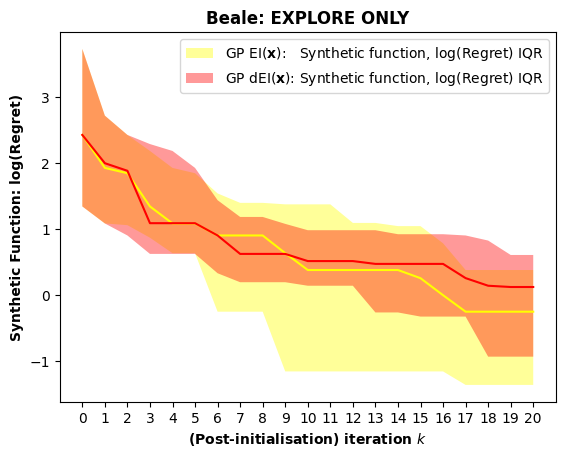

In [163]:
### Visualise!

ei_explore = ': EXPLORE ONLY'
title = obj_func + ei_explore

plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI($\mathbf{x}$):   Synthetic function, log(Regret) IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='GP dEI($\mathbf{x}$): Synthetic function, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show()


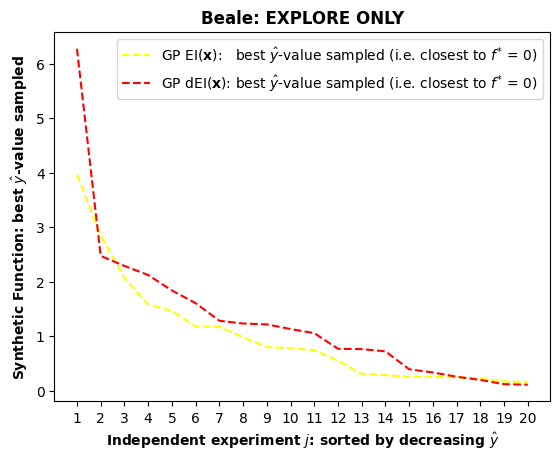

In [164]:
### Visualise!

ei_explore = ': EXPLORE ONLY'
title = obj_func + ei_explore

plt.figure()

plt.plot(np.sort(approx_tau)[::-1], color = 'Yellow', ls='--', label='GP EI($\mathbf{x}$):   best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = 0)')
plt.plot(np.sort(exact_tau)[::-1], color = 'Red', ls='--', label='GP dEI($\mathbf{x}$): best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = 0)')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$: sorted by decreasing $\it{\hat{y}}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: best $\it{\hat{y}}$-value sampled', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


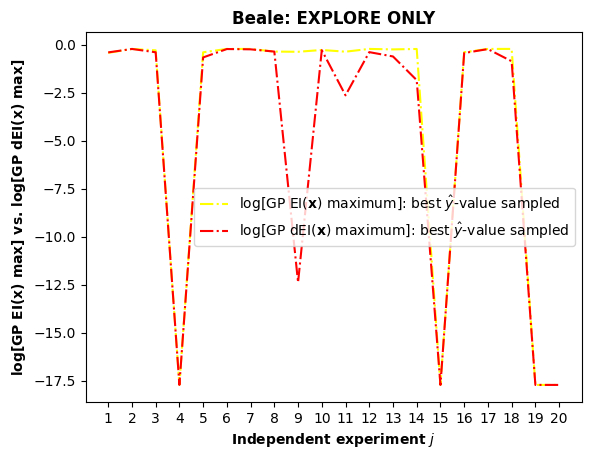

In [165]:
### Visualise!

ei_explore = ': EXPLORE ONLY'
title = obj_func + ei_explore

plt.figure()

plt.plot(np.log(exact_acqFuncApproxBest), color = 'Yellow', ls='-.', label='log[GP EI($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')
plt.plot(np.log(exact_acqFuncExactBest), color = 'Red', ls='-.', label='log[GP dEI($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('log[GP EI($\mathbf{x}$) max] vs. log[GP dEI($\mathbf{x}$) max]', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


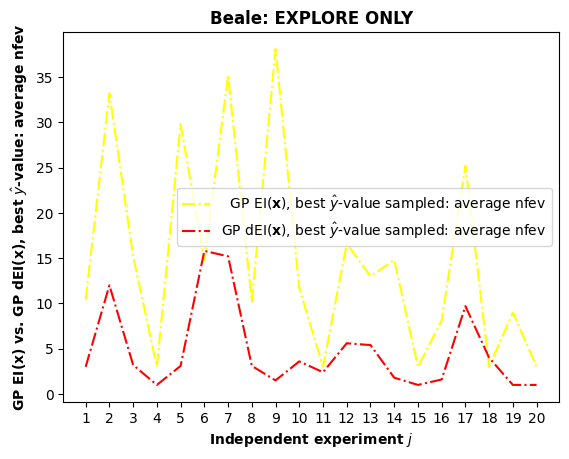

In [166]:
### Visualise!

ei_explore = ': EXPLORE ONLY'
title = obj_func + ei_explore

plt.figure()

plt.plot(approx_nfev_Avg, color = 'Yellow', ls='-.', label='  GP EI($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')
plt.plot(exact_nfev_Avg, color = 'Red', ls='-.', label='GP dEI($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP EI($\mathbf{x}$) vs. GP dEI($\mathbf{x}$), best $\it{\hat{y}}$-value: average nfev', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


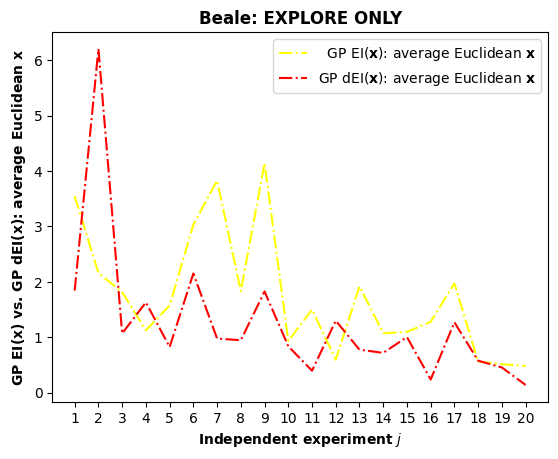

In [167]:
### Visualise!

ei_explore = ': EXPLORE ONLY'
title = obj_func + ei_explore

plt.figure()

plt.plot(approx_euclid_Avg, color = 'Yellow', ls='-.', label='  GP EI($\mathbf{x}$): average Euclidean $\mathbf{x}$')
plt.plot(exact_euclid_Avg, color = 'Red', ls='-.', label='GP dEI($\mathbf{x}$): average Euclidean $\mathbf{x}$')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP EI($\mathbf{x}$) vs. GP dEI($\mathbf{x}$): average Euclidean $\mathbf{x}$', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


In [168]:
np.round(-approx_4.f_best, 4), np.max(np.round(-approx_4.f_best, 4)), approx_4.best


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 0.0,
 array([ 3.84477303, -0.64811126]))

In [169]:
np.round(-approx_4.f_best2, 4), np.max(np.round(-approx_4.f_best2, 4)), approx_4.best2


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 0.0,
 array([ 3.84477303, -0.64811126]))

In [170]:
np.round(approx_4.x_best, 4)


array([[-1.211 , -0.2553],
       [-4.3683, -2.832 ],
       [ 0.5022,  1.5938],
       [ 1.3008,  4.028 ],
       [-1.2393,  3.2584],
       [ 2.2579,  1.7829],
       [ 3.094 ,  3.5193],
       [ 1.7737, -3.9383],
       [-2.7917,  0.5702],
       [ 0.4952,  4.2244],
       [ 0.5914,  2.7947],
       [ 1.1803, -3.6823],
       [-1.2694, -0.2297],
       [-3.1738, -0.3069],
       [ 0.7888,  2.6758],
       [ 1.4255,  3.1558],
       [ 3.2391, -3.9201],
       [ 3.8448, -0.6481],
       [ 1.1442, -1.9423],
       [-1.8664, -0.0634]])

In [171]:
np.round(approx_4.x_best2, 4)


array([[-1.211 , -0.2553],
       [-4.3683, -2.832 ],
       [ 0.5022,  1.5938],
       [ 1.3008,  4.028 ],
       [-1.2393,  3.2584],
       [ 2.2579,  1.7829],
       [ 3.094 ,  3.5193],
       [ 1.7737, -3.9383],
       [-2.7917,  0.5702],
       [ 0.4952,  4.2244],
       [ 0.5914,  2.7947],
       [ 1.1803, -3.6823],
       [-1.2694, -0.2297],
       [-3.1738, -0.3069],
       [ 0.7888,  2.6758],
       [ 1.4255,  3.1558],
       [ 3.2391, -3.9201],
       [ 3.8448, -0.6481],
       [ 1.1442, -1.9423],
       [-1.8664, -0.0634]])

In [172]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best)**2))


0.0

In [173]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best2)**2))

0.0